In [1]:
import scanpy as sc 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
import scipy
import os

from utils import plot_histogram
from var import *
from guide_assignment import *

In [2]:
#set seed to 0 for reproducibility of results
np.random.seed(0)

In [3]:
#define which dataset to use
dataset = '49_03_l1_crispra_5_gex'

In [4]:
#Create figures folder
figures_folder = os.path.join(results_folder, f'figures/{dataset}/guide_assignment/')
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

In [5]:
#set global matplotlib parameters font size to 14
plt.rcParams.update({'font.size': 14})


## 1. Assessing extent of guide overassignment issue

In [6]:
#load raw anndata object
adata = sc.read_h5ad('/lustre/scratch123/hgi/teams/parts/kl11/cell2state_tf_activation/results/20230306_adata_49_03_l1_crispra_5_gex_pre_processed_filtered_above_5000.h5ad')

In [7]:
#drop all columns with 0 guide counts in adata.obsm guide counts
adata.obsm['guide_counts'] = adata.obsm['guide_counts'].loc[:,np.sum(adata.obsm['guide_counts'],axis=0)>0]

In [8]:
#assign guide barcode availability to adata obs
adata.obs['guide_barcodes'] = adata.obsm['guide_counts'].sum(axis=1) > 0
#change true/false to available/not available
adata.obs['guide_barcodes'] = adata.obs['guide_barcodes'].replace({True:'available', False:'not available'})

/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


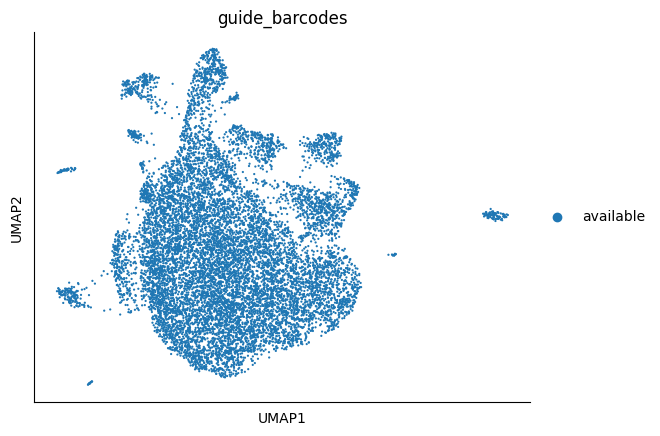

In [13]:
#plot umap of guide barcode availability
sc.pl.umap(adata, color='guide_barcodes')

In [9]:
#create pre-processed anndata layer
adata.layers['pre_processed'] = adata.X.copy()
#use raw counts as data
adata.X = adata.layers['counts']

In [10]:
#load experimental design
experimental_design = pd.read_csv('/lustre/scratch123/hgi/teams/parts/kl11/cell2state_tf_activation/data/49_03_exp_design_20221124 - Sheet1.csv')

In [11]:
#function pivot experimental design data from wide to long format
def pivot_experimental_design(df):
    '''
    Pivot experimental design data from wide to long format with data wrangling to match barcode count data

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the experimental design data
    Returns
    -------
    df_long : pd.DataFrame
        DataFrame containing the experimental design data in long format
        
    '''
    # create index by merging all columns containing pertubation in column name
    df['perturbation'] = df.filter(regex='perturbation').apply(lambda x: '_'.join(x.dropna().astype(str)), axis=1)
    # drop double control condition by dropping duplicates
    df = df.drop_duplicates(subset='perturbation', keep='first')
    #convert all columns header to string
    df.columns = df.columns.astype(str)

    # pivot experimental design data from wide to long format drop variable column
    guide_col=df.columns[df.columns.str.startswith('guide')]
    df_long = pd.melt(df, id_vars=['perturbation','number_of_pert'], value_vars=guide_col, var_name='guide_no', value_name='guide')
    df_long = df_long.drop(columns=['guide_no'])
    # sort rows by perturbation
    df_long = df_long.sort_values(by=['perturbation'])
    # drop all nan columns in guide column
    df_long = df_long.dropna(subset=['guide'])
    #in grna column replace regex r'+\d+' with ''
    df_long['guide'] = df_long['guide'].str.replace(r'\+.+', '', regex=True)
    #create a columns with target gene name by splitting guide column on '_'
    df_long['guide_target_gene'] = df_long['guide'].str.split('_gRNA').str[0]
    df_long['guide_target_gene'] = df_long['guide_target_gene'].str.split('_gRNA').str[0]
    # #for CONTROL condition set target gene to 'CONTROL'
    # df_long.loc[df_long['perturbation'] == 'CONTROL', 'guide_target_gene'] = 'CONTROL'

    return df_long

In [12]:
experimental_design_long = pivot_experimental_design(experimental_design)

### 1.2 guide UMI count distribution

AIRE_ACAGCAGCGCCTCCATCACA_AIRE_CGGAGACTTCCCGAGAGCGA_1                                             542263.0
AIRE_ACAGCAGCGCCTCCATCACA_AIRE_CGGAGACTTCCCGAGAGCGA_2                                                 97.0
AIRE_ATCACAGGGAAGTGTCCCTG_AIRE_CAGGGAAGTGTCCCTGCGGG_1                                              80763.0
AIRE_ATCACAGGGAAGTGTCCCTG_AIRE_CAGGGAAGTGTCCCTGCGGG_2                                             139395.0
ASCL1_AGCCGCTCGCTGCAGCAGCG_ASCL1_GGAGGGGGAGTTTAGGGAGT_1                                           449543.0
ASCL1_AGCCGCTCGCTGCAGCAGCG_ASCL1_GGAGGGGGAGTTTAGGGAGT_2                                            56769.0
ASCL1_CTCCCCGCTGCTGCAGCGAG_ASCL1_GCAGCCGCTCGCTGCAGCAG_1                                           156544.0
ASCL1_CTCCCCGCTGCTGCAGCGAG_ASCL1_GCAGCCGCTCGCTGCAGCAG_2                                           727925.0
DBX2_CCGTCCAGATCTGCATAGAG_DBX2_GTCCAGATCTGCATAGAGAG_2                                                  9.0
DLX1_AAAGCTTTGAACCGAGTTTG_DLX1_CCAGTG

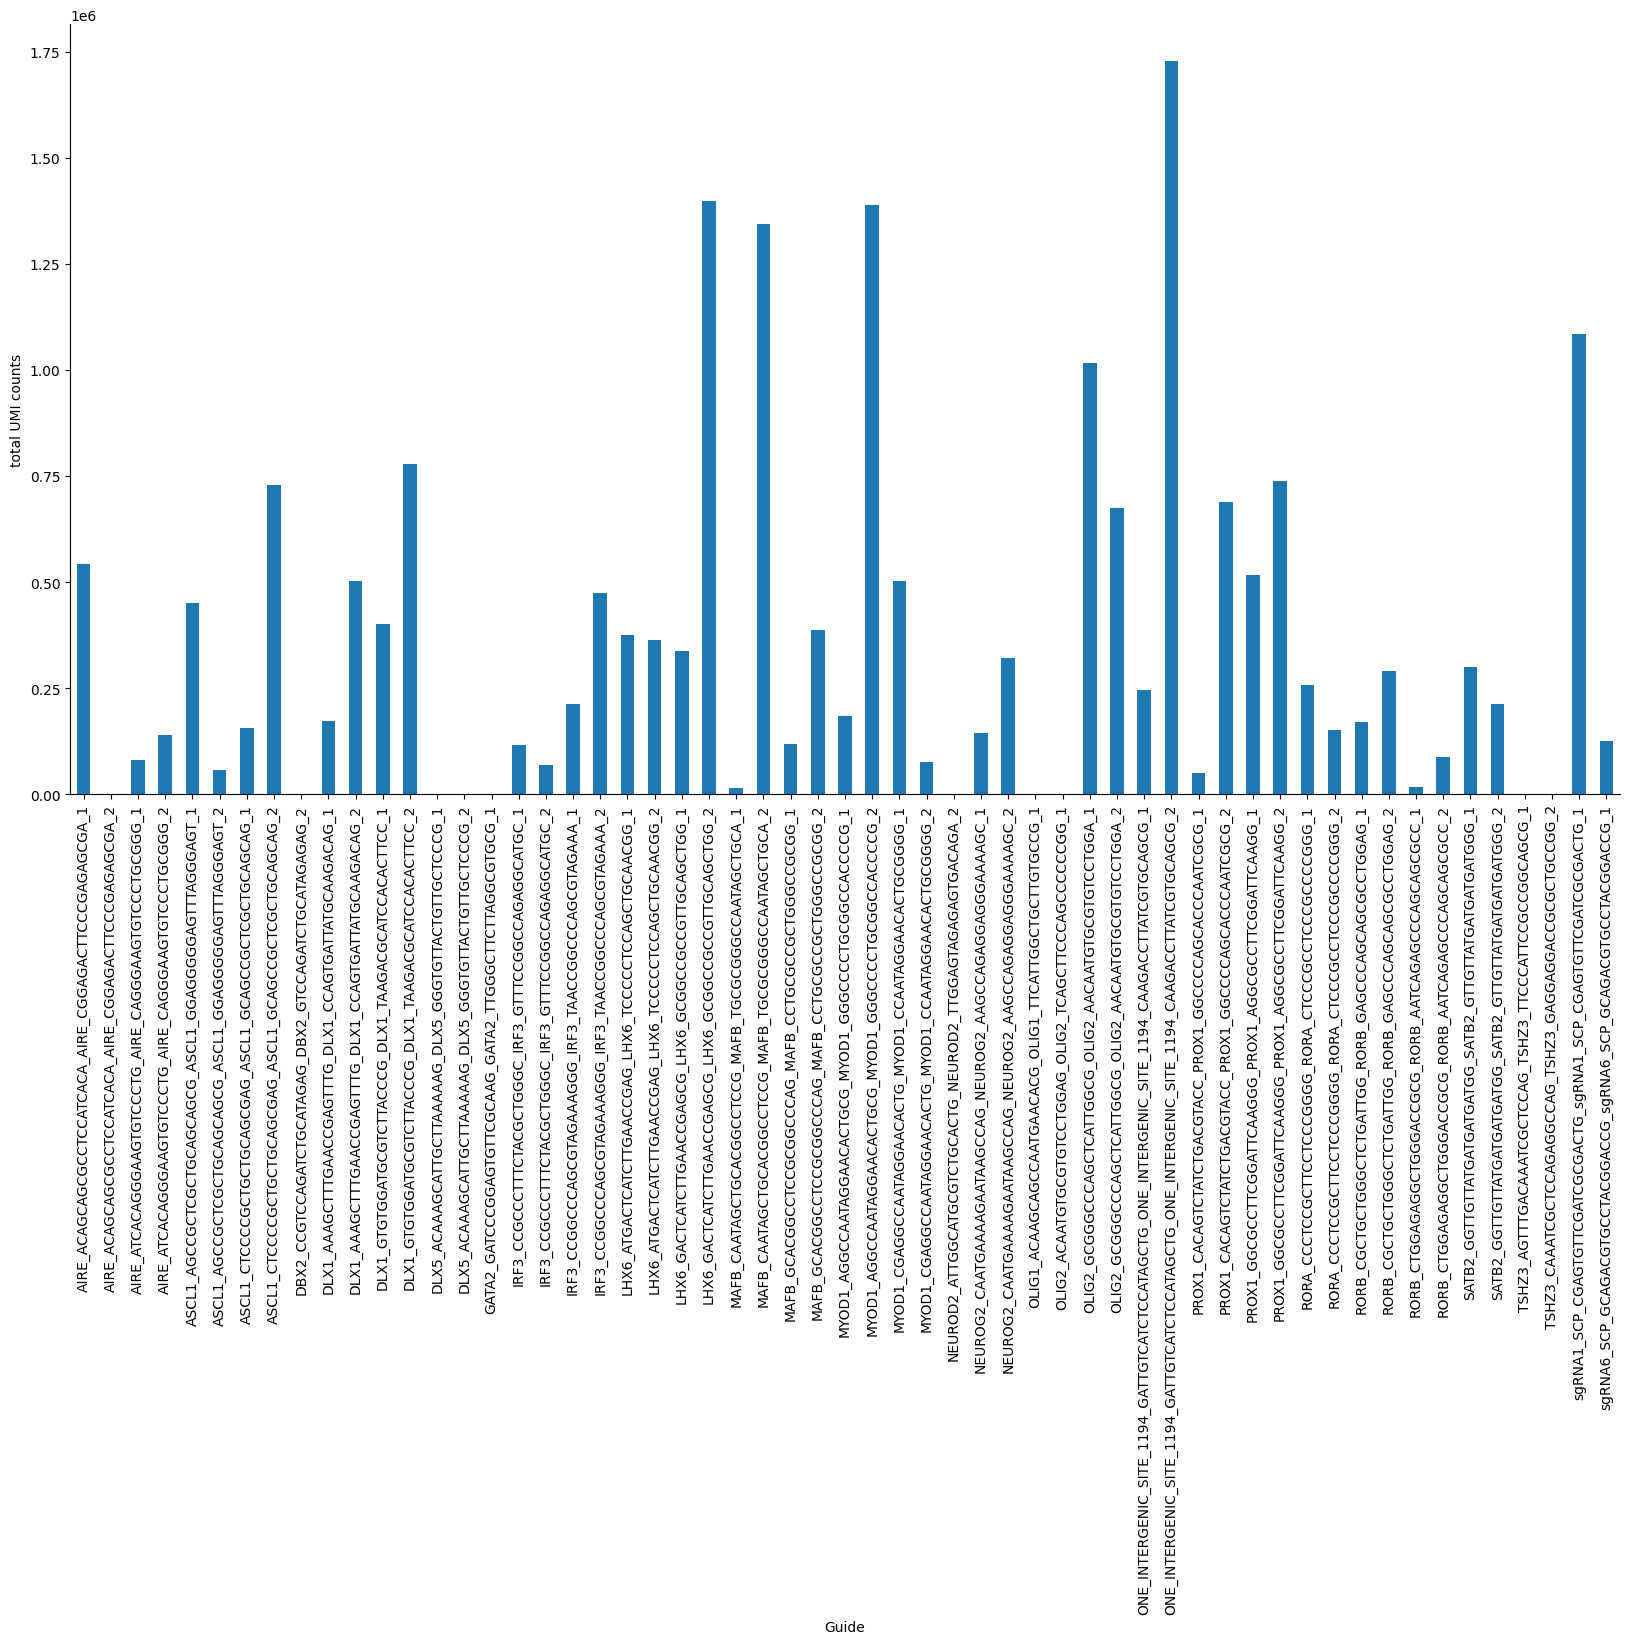

In [18]:
#plot total guide UMI counts from adata.obsm['guide_counts']
# order columns alphabetically
adata.obsm['guide_counts'] = adata.obsm['guide_counts'].reindex(sorted(adata.obsm['guide_counts'].columns), axis=1)
adata.obsm['guide_counts'].sum(axis=0).plot(kind='bar', figsize=(20,10))
# add x and y labels
plt.xlabel('Guide')
plt.ylabel('total UMI counts')
# save figure
plt.savefig(os.path.join(figures_folder, f'{today}_guide_UMI_counts.pdf'), dpi=300, bbox_inches='tight')
print(adata.obsm['guide_counts'].sum(axis=0))

Text(0, 0.5, 'average UMI counts/cell')

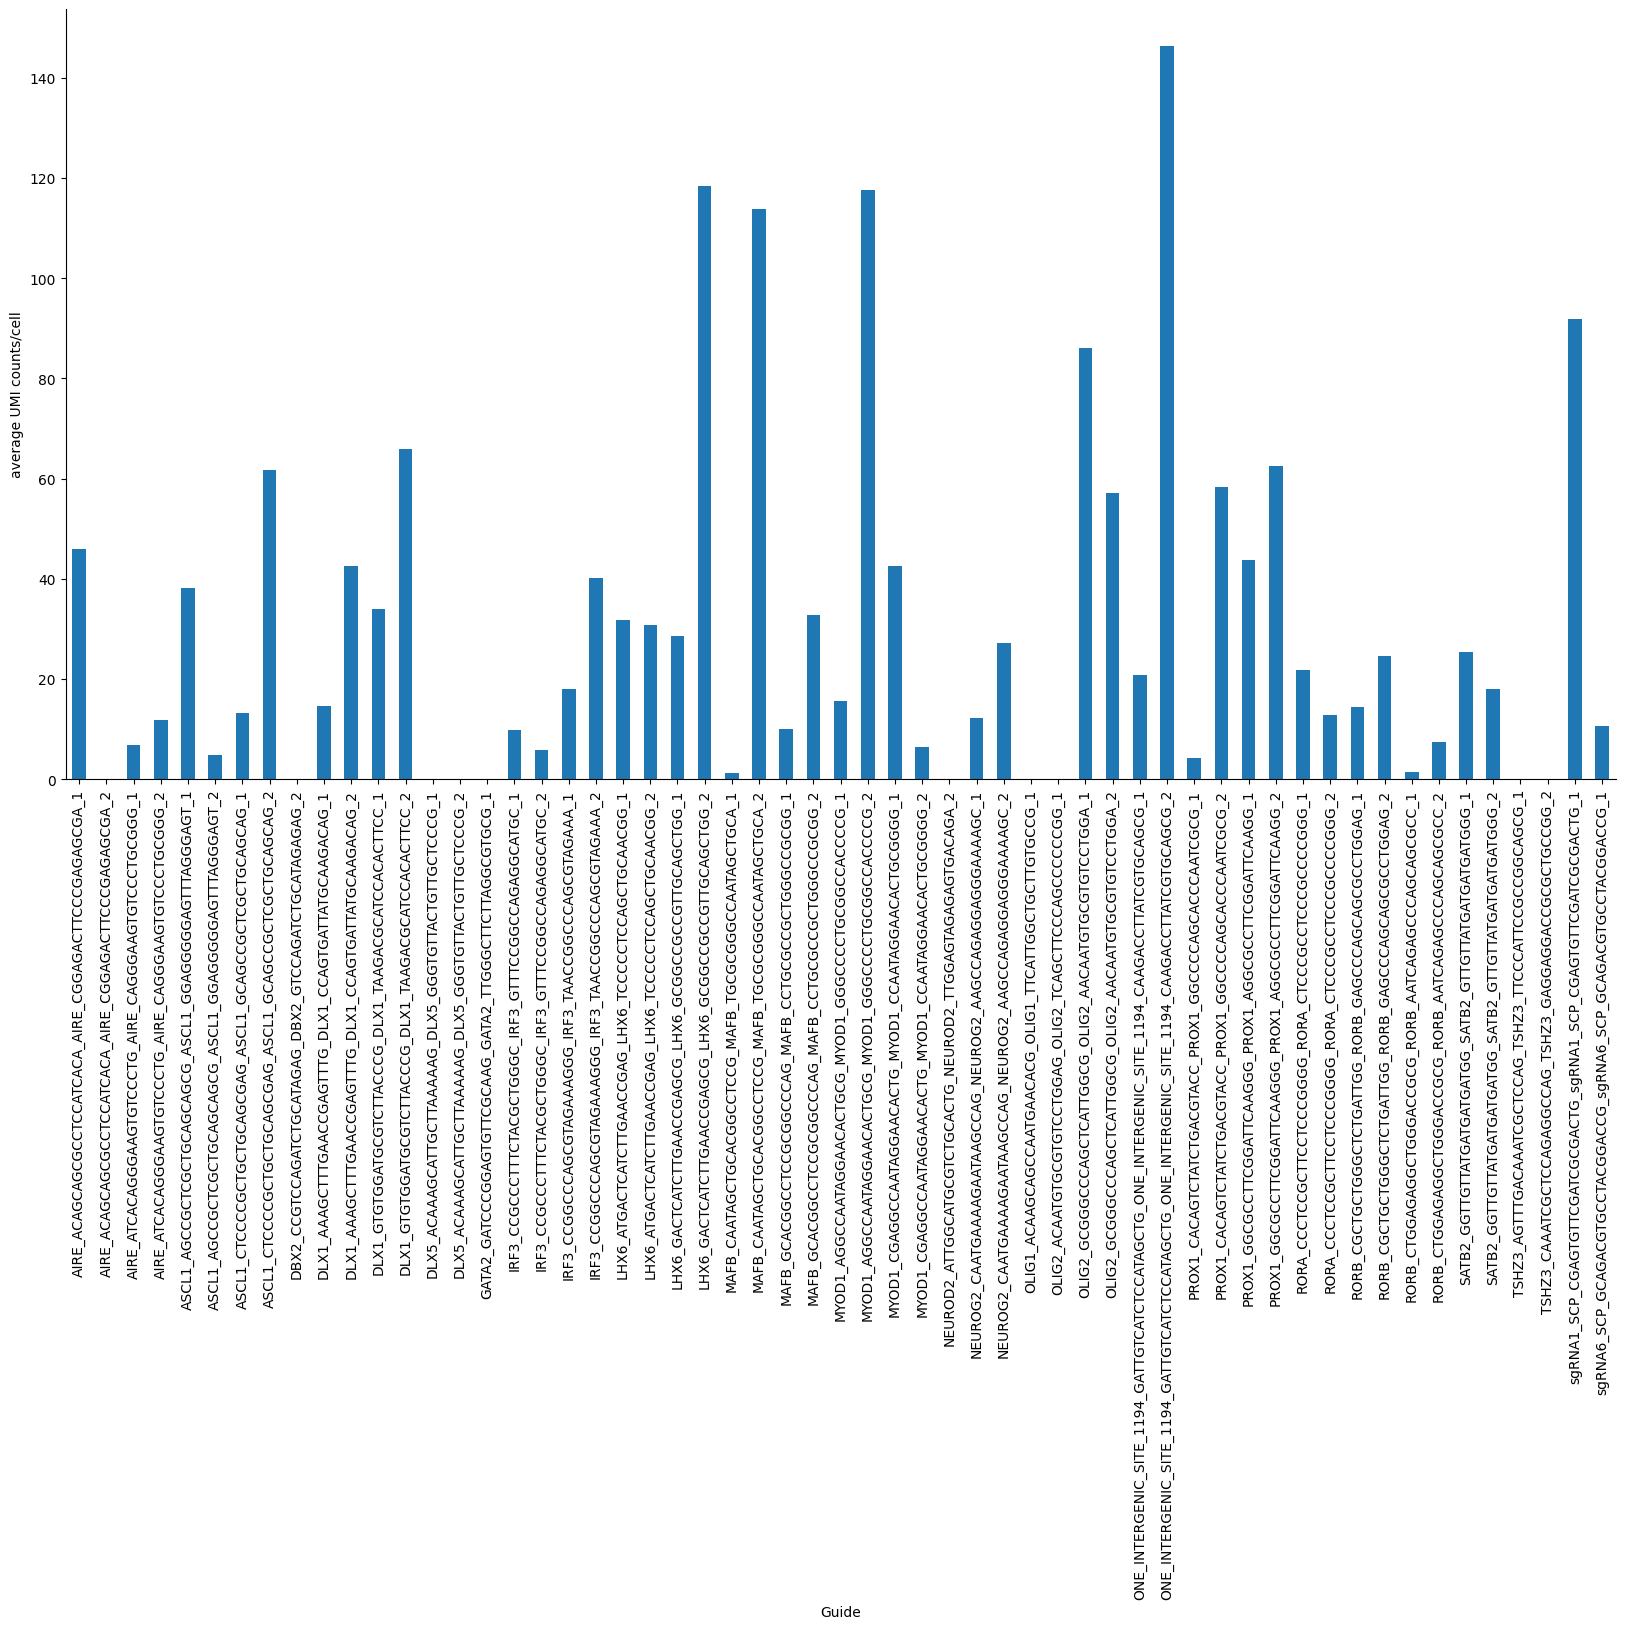

In [22]:
#plot average guide UMI counts/cell from adata.obsm['guide_counts']
# order columns alphabetically
adata.obsm['guide_counts'] = adata.obsm['guide_counts'].reindex(sorted(adata.obsm['guide_counts'].columns), axis=1)
adata.obsm['guide_counts'].mean(axis=0).plot(kind='bar', figsize=(20,10))
# add x and y labels
plt.xlabel('Guide')
plt.ylabel('average UMI counts/cell')

Text(0, 0.5, 'Number of cells with guide barcode counts')

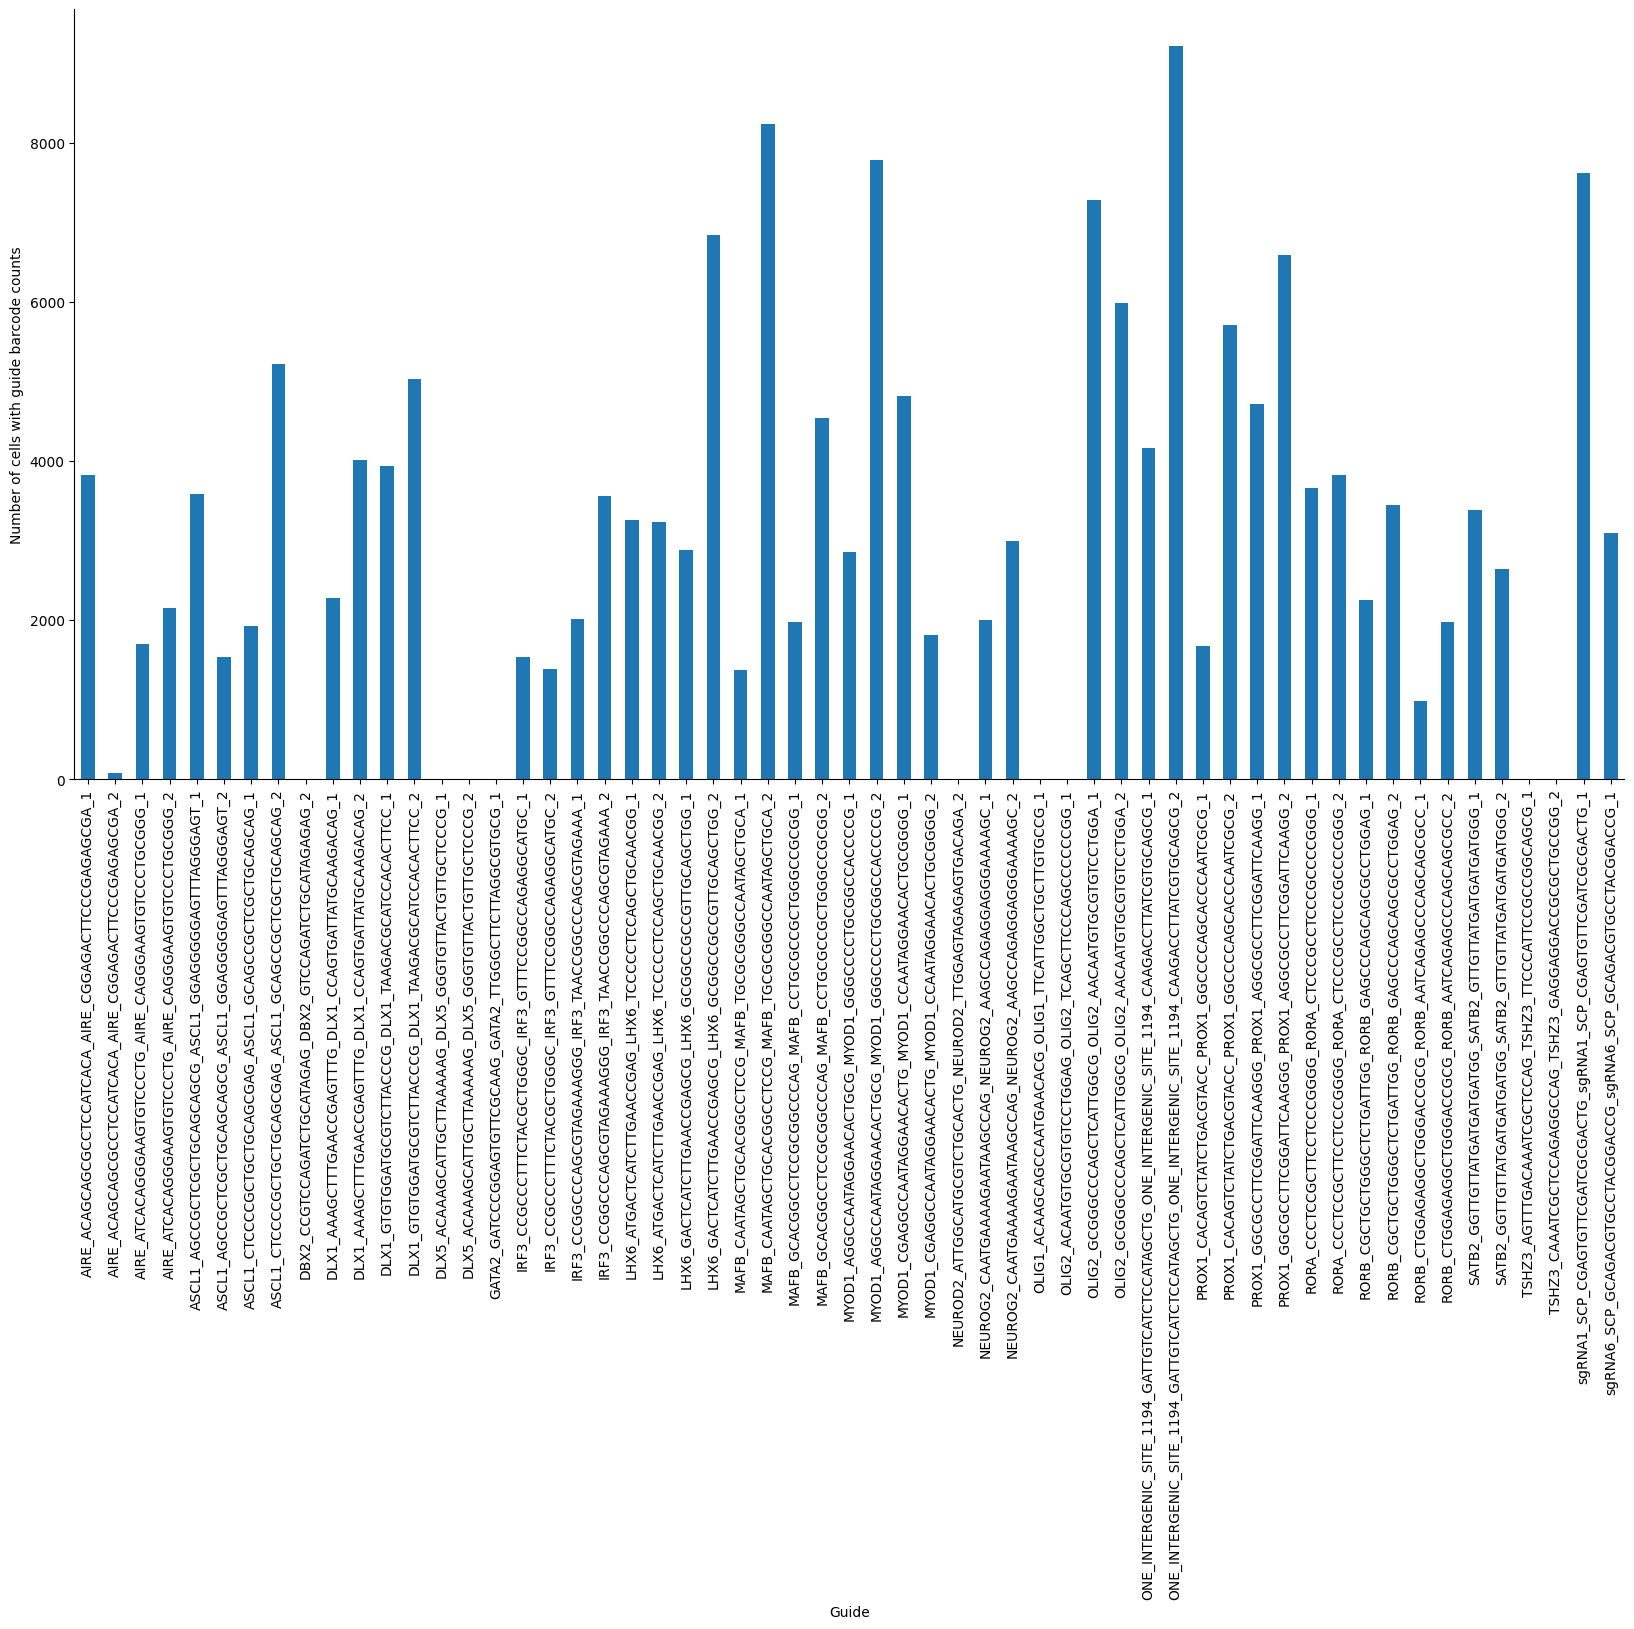

In [23]:
#plot the amount of cells with a guide barcode for each guide
# order columns alphabetically
#count non zero values per column
adata.obsm['guide_counts'] = adata.obsm['guide_counts'].reindex(sorted(adata.obsm['guide_counts'].columns), axis=1)
adata.obsm['guide_counts'].astype(bool).sum(axis=0).plot(kind='bar', figsize=(20,10))
# add x and y labels
plt.xlabel('Guide')
plt.ylabel('Number of cells with guide barcode counts')

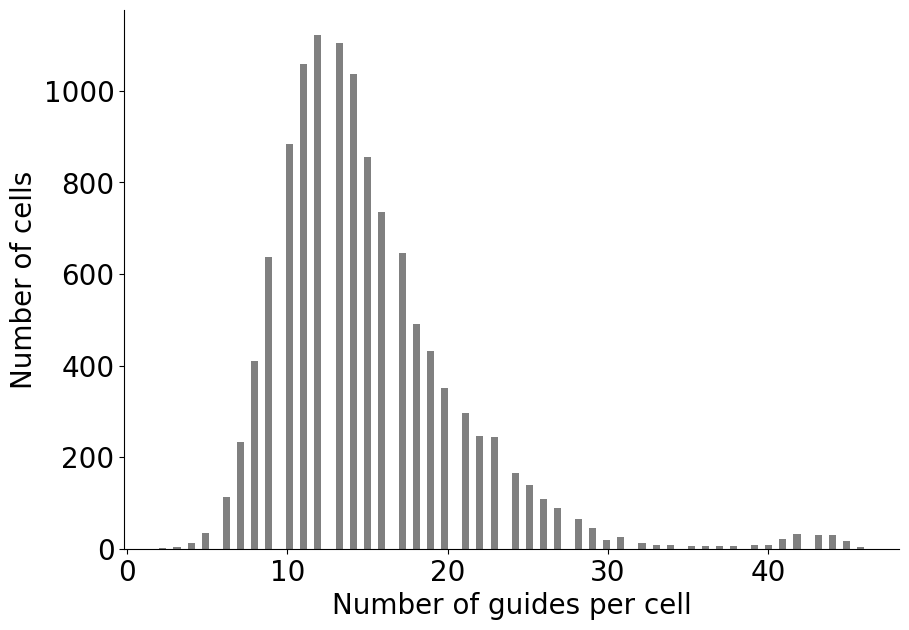

In [29]:
#count number of unique guide per cell by counting number of all non-zero values in each row
guide_per_cell = np.count_nonzero(adata.obsm['guide_counts'], axis=1)
fig, ax = plt.subplots(figsize=(10,7))

#plot histogram of guide per cell in grey
plt.hist(guide_per_cell, bins=100, color='grey')
# add x and y labels
plt.xlabel('Number of guides per cell')
plt.ylabel('Number of cells')
#change font size
plt.rcParams.update({'font.size': 20})

# save figure
plt.savefig(os.path.join(figures_folder, f'{today}_unique_guides_per_cell.pdf'), dpi=300, bbox_inches='tight')

### 1.3 Guide assignment

#### 1.3.1 Guide fraction for guide pool

In [35]:
#write a function to extract all unique targets appearing in multiple perturbations
def extract_multiple_pert_targets(experimental_design_long):
    """
    This function extracts all unique targets appearing in multiple perturbations from the experimental design long format dataframe.
    Parameters
    ----------
    experimental_design_long : pd.DataFrame
        Long format dataframe with experimental design.

    Returns
    -------
    multiple_pert_targets : list
        List of all unique targets appearing in multiple perturbations.

    """
    # subset experimental design long for multiple perturbations
    multiple_pert = experimental_design_long[experimental_design_long['number_of_pert'] > 1]
    #extract all unique targets appearing in multiple perturbations
    multiple_pert_targets = multiple_pert['perturbation'].unique()
    multiple_pert_targets = [string.split('_') for string in  multiple_pert_targets]
    #flatten list
    multiple_pert_targets = [item for sublist in multiple_pert_targets for item in sublist]
    #unique elements
    multiple_pert_targets = list(set(multiple_pert_targets))
    
    return multiple_pert_targets


In [36]:
multiple_pert_targets = extract_multiple_pert_targets(experimental_design_long)

In [37]:
multiple_pert_targets

['CONTROL', 'RORA', 'RORB']

In [49]:
#write function for 1d hist plot
def plot_1d_hist(filtered_pert_frac, filtered_pert_count, pert_string, path_to_save=None):
        """
        This function plots a 1d histogram of guide fraction per cell and guide counts per cell for a given perturbation.
        Parameters
        ----------
        filtered_pert_frac : pd.DataFrame
                Dataframe with guide fraction per cell for each perturbation.
        filtered_pert_count : pd.DataFrame
                Dataframe with guide counts per cell for each perturbation.
        pert_string : list
                List of strings containing the perturbation name.
        path_to_save : str, optional
                Path to save figure. The default is None.
        Returns
        -------
        None.
        """
        #assert that pert_string has only one element
        assert len(pert_string) == 1, 'pert_string should only contain one element'
        #initialise figure and axes with two subplots
        fig, ax = plt.subplots(1, 2, figsize=(20,8))
        # set title of whole figure
        fig.suptitle(f'{pert_string[0]}')

        # plot histogram of guide fraction per cell using pert_frac
        ax[0].hist(filtered_pert_frac[pert_string[0]], bins=50,color='grey')
        # add x and y labels
        ax[0].set_xlabel(f'{pert_string[0]} guide fraction per cell')
        ax[0].set_ylabel(f'Number of cells')

        # plot histogram of guide counts per cell using pert_count
        # add x and y labels
        ax[1].hist(filtered_pert_count[pert_string[0]], bins=100, color='grey')
        ax[1].set_xlabel(f'{pert_string[0]} guide counts per cell')
        ax[1].set_ylabel('Number of cells')
        #change x axis ticks to scientific notation
        ax[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        # #limit x axis to 1000
        # ax[1].set_xlim(0, 100)
        #change font size
        plt.rcParams.update({'font.size': 20})
        #change number of ticks on x and y axis to 4
        ax[0].xaxis.set_major_locator(plt.MaxNLocator(5))
        ax[0].yaxis.set_major_locator(plt.MaxNLocator(5))
        ax[1].xaxis.set_major_locator(plt.MaxNLocator(5))
        ax[1].yaxis.set_major_locator(plt.MaxNLocator(5))

        if path_to_save:
                # save figure
                plt.savefig(path_to_save, dpi=300, bbox_inches='tight')


In [55]:
#write function for 2d hist plot
def plot_2d_hist(filtered_pert_frac, filtered_pert_count, pert_string, path_to_save=None):
        """
        This function plots a 2d histogram of guide fraction per cell and guide counts per cell for a given perturbation.
        Parameters
        ----------
        filtered_pert_frac : pd.DataFrame
                Dataframe with guide fraction per cell for each perturbation.
        filtered_pert_count : pd.DataFrame
                Dataframe with guide counts per cell for each perturbation.
        pert_string : list
                List of strings containing the perturbation name.
        path_to_save : str, optional
                Path to save figure. The default is None.
        Returns
        -------
        None.
        """
        #assert that pert_string has only one element
        assert len(pert_string) == 2, 'pert_string should contain two elements'
        #initialise figure and axes with two subplots
        fig, ax = plt.subplots(1, 2, figsize=(20,10))
        # set title of whole figure
        fig.suptitle(f'{pert_string[0]}_{pert_string[1]}')

        # plot histogram of guide fraction per cell using pert_frac
        ax[0].hist2d(filtered_pert_frac[pert_string[0]], filtered_pert_frac[pert_string[1]], bins=50, norm=colors.LogNorm(), cmap='viridis')
        # add x and y labels
        ax[0].set_xlabel(f'{pert_string[0]} guide fraction per cell',fontsize=20)
        ax[0].set_ylabel(f'{pert_string[1]} guide fraction per cell', fontsize=20)

        # plot histogram of guide counts per cell using pert_count
        # add x and y labels
        ax[1].hist2d(filtered_pert_count[pert_string[0]], filtered_pert_count[pert_string[1]], bins=50, cmap='viridis', norm=colors.LogNorm())
        #change label font size to 20
        ax[1].set_xlabel(f'{pert_string[0]} guide counts per cell', fontsize=20)
        ax[1].set_ylabel(f'{pert_string[1]} guide counts per cell', fontsize=20)

        if path_to_save:
                # save figure
                # plt.savefig(os.path.join(figures_folder, f'{today}_{pert}_guide_fraction.pdf'), dpi=300, bbox_inches='tight')
                plt.savefig(path_to_save, dpi=300, bbox_inches='tight')

In [51]:
#plot 3d scatter plot
def plot_3d_scatter(filtered_pert_frac, filtered_pert_count, pert_string, path_to_save=None):
        """
        This function plots a 3d scatter plot of guide fraction per cell and guide counts per cell for a given perturbation.
        Parameters
        ----------
        filtered_pert_frac : pd.DataFrame
                Dataframe with guide fraction per cell for each perturbation.
        filtered_pert_count : pd.DataFrame
                Dataframe with guide counts per cell for each perturbation.
        pert_string : list
                List of strings containing the perturbation name.
        path_to_save : str, optional
                Path to save figure. The default is None.
        Returns
        -------
        None.
        """
        #assert that pert_string has only one element
        assert len(pert_string) == 3, 'pert_string should contain three elements'

        #initialise figure and axes with two subplots
        fig, ax = plt.subplots(1, 2, figsize=(20,10))
        # turn off axis
        ax[0].axis('off')
        ax[1].axis('off')
        # set title of whole figure
        fig.suptitle(f'{pert_string[0]}_{pert_string[1]}_{pert_string[2]}')
        # set 3d figure
        ax[0] = fig.add_subplot(1, 2, 1, projection='3d')
        ax[1] = fig.add_subplot(1, 2, 2, projection='3d')
        # tight layout
        fig.tight_layout()
        # plot 3d scatter plot
        ax[0].scatter(filtered_pert_frac[pert_string[0]], filtered_pert_frac[pert_string[1]], filtered_pert_frac[pert_string[2]], marker='o', alpha=0.5, c='grey')
        # add x, y and z labels
        ax[0].set_xlabel(f'{pert_string[0]} guide fraction per cell')
        ax[0].set_ylabel(f'{pert_string[1]} guide fraction per cell')
        ax[0].set_zlabel(f'{pert_string[2]} guide fraction per cell')

        ax[1].scatter(filtered_pert_count[pert_string[0]], filtered_pert_count[pert_string[1]], filtered_pert_count[pert_string[2]], marker='o', alpha=0.5,c='grey')
        # add x, y and z labels
        ax[1].set_xlabel(f'{pert_string[0]} guide count per cell')
        ax[1].set_ylabel(f'{pert_string[1]} guide count per cell')
        ax[1].set_zlabel(f'{pert_string[2]} guide count per cell')


        if path_to_save:
                # save figure
                # plt.savefig(os.path.join(figures_folder, f'{today}_{pert}_guide_fraction.pdf'), dpi=300, bbox_inches='tight')
                plt.savefig(path_to_save, dpi=300, bbox_inches='tight')

In [52]:
experimental_design_long.columns

Index(['perturbation', 'number_of_pert', 'guide', 'guide_target_gene'], dtype='object')

In [53]:


def assign_perturbation_state(adata, experimental_design_long, figures_folder, count_threshold=0, frac_threshold=0.5):
    """
    This function assigns a perturbation state to each cell based on the guide fraction per cell and guide counts per cell. 
    It further plots a histogram/scatter plot of guide fraction per cell and guide counts per cell for each perturbation; its dimensions are determined by the number of guides per perturbation.
    Parameters
    ----------
    adata : AnnData
            AnnData object containing the barcode counts per cell.
    experimental_design_long : pd.DataFrame
            Dataframe containing the experimental design with one row per guide for all perturbation combination.
    figures_folder : str
            Path to save figures.
    count_threshold : int, optional
            Threshold for guide counts per cell. The default is 0, so that at least one guide has to be expressed.
    frac_threshold : float, optional
            Threshold for guide fraction per cell. The default is 0.5, as this guarantees that each cell is mapped distinctly to a perturbation state.
    Returns
    -------
    adata : AnnData
            AnnData object containing the barcode counts per cell and a new column 'pert_state' with the perturbation state of each cell.
    """
    #assign new columnt to assign perturbation state
    adata.obs['pert_state'] = 'not_perturbed'

    for pert in experimental_design_long['perturbation'].unique():
        print(pert)

        #create figures folder if it does not exist
        tmp_figures_folder = os.path.join(figures_folder, 'perturbation_frac_counts')
        if not os.path.exists(tmp_figures_folder):
                os.makedirs(tmp_figures_folder)

        #filter for guides of perturbation
        guides = experimental_design_long[experimental_design_long['perturbation'] == pert]['guide_target_gene'].unique()   

        #split perturbation string
        pert_string = pert.split('_')
        #def function to filter for current guides
        def filter_guides(pert):

               
               guides_of_interest = experimental_design_long[experimental_design_long['perturbation'] == pert]['guide_target_gene'].unique()
               
               if len(guides_of_interest) == 0:
                      guides_of_interest = experimental_design_long.loc[experimental_design_long['guide_target_gene'].str.contains(pert)]['guide_target_gene'].unique()
               #filter adata obsm guide_counts for guides of interest
 
               return adata.obsm['guide_counts'].loc[:,adata.obsm['guide_counts'].columns.str.contains('|'.join(guides_of_interest))]


        #sum for each perturbation the number of counts per cell with dict comprehension by summing row-wise adatas obsm['guide_counts'] 
        pert_count = {
               pert: 
               filter_guides(pert).sum(axis=1)
               for pert in pert_string
               }

        #calculate fraction of perturbation counts per cell
        pert_frac = {k: v / adata.obsm['guide_counts'].sum(axis=1) for k, v in pert_count.items()}
        #fill all nan values with 0 in pert_frac
        pert_frac = {k: v.fillna(0) for k, v in pert_frac.items()}
        #create path to save figure
        path_to_save = os.path.join(tmp_figures_folder, f'{today}_{pert}.pdf')
        
        print(len(pert_string))
        # check if string contains any of the multiple perturbations
        if any(x in pert for x in multiple_pert_targets):

                if len(pert_string)==1:
                        # extract all conditions where pert is one of the multiple perturbations
                        conditions = experimental_design_long[experimental_design_long['perturbation'].str.contains(pert)]['perturbation'].unique()
                        # split conditions by '_'
                        conditions = [string.split('_') for string in conditions]
                        # flatten list
                        conditions = [item for sublist in conditions for item in sublist]
                        # remove pert from conditions
                        conditions_to_exclude = [x for x in conditions if x != pert]
                        # extract list of guides for conditions to exclude based on guide_target_gene column 
                        guides_to_exclude = experimental_design_long[experimental_design_long['guide_target_gene'].isin(conditions_to_exclude)]['guide_target_gene'].unique()
                        #join guides_to_exclude with '|' for regex
                        guides_to_exclude = '|'.join(guides_to_exclude)

                        
                        #create boolean conditions and apply to pert_count and pert_frac
                        #boolean mask to filter for cells with >0 guide count per cell
                        tmp_count_mask = filter_guides(pert).sum(axis=1) > count_threshold
                        #boolean mask for guides to exclude all counts need to be 0 
                        tmp_count_mask = tmp_count_mask & (adata.obsm['guide_counts'].loc[:,adata.obsm['guide_counts'].columns.str.contains(guides_to_exclude)].sum(axis=1) == 0)
                        #apply mask to pert_count and pert_frac
                        filtered_pert_count = {k: v[tmp_count_mask] for k, v in pert_count.items()}
                        filtered_pert_frac = {k: v[tmp_count_mask] for k, v in pert_frac.items()}

                        #plot 1d hist for one condition
                        plot_1d_hist(filtered_pert_frac, filtered_pert_count, pert_string, path_to_save)

                #plot hist2d for two conditions
                elif len(pert_string)==2:
                        # boolean mask to filter for cells with each pert count per cell >0  in pert_count
                        tmp_count_mask = (pert_count[pert_string[0]] > count_threshold) & (pert_count[pert_string[1]] > count_threshold)
                        # apply mask to pert_count and pert_frac
                        filtered_pert_count = {k: v[tmp_count_mask] for k, v in pert_count.items()}
                        filtered_pert_frac = {k: v[tmp_count_mask] for k, v in pert_frac.items()}

                        #plot 2d hist for two conditions
                        plot_2d_hist(filtered_pert_frac, filtered_pert_count, pert_string, path_to_save)

                elif len(pert_string)==3:
                        #plot 3d scatter plot
                        # boolean mask to filter for cells with each pert count per cell >0  in pert_count
                        tmp_count_mask = (pert_count[pert_string[0]] > count_threshold) & (pert_count[pert_string[1]] > count_threshold) & (pert_count[pert_string[2]] > count_threshold)
                        # apply mask to pert_count and pert_frac
                        filtered_pert_count = {k: v[tmp_count_mask] for k, v in pert_count.items()}
                        filtered_pert_frac = {k: v[tmp_count_mask] for k, v in pert_frac.items()}

                        #plot 3d scatter plot
                        plot_3d_scatter(filtered_pert_frac, filtered_pert_count, pert_string, path_to_save)

        
        else:
                # create boolean mask to filter for cells with >1 guide count per cell
                tmp_count_mask = filter_guides(pert).sum(axis=1) > count_threshold
                # apply mask to pert_count and pert_frac
                filtered_pert_count = {k: v[tmp_count_mask] for k, v in pert_count.items()}
                filtered_pert_frac = {k: v[tmp_count_mask] for k, v in pert_frac.items()}

                #plot hist1d
                plot_1d_hist(filtered_pert_frac, filtered_pert_count, pert_string, path_to_save)

        #assign perturbation state based on summed frequency of perturbation guides per cell
        #extract all list from dict
        tmp_list = list(filtered_pert_frac.values())
        #sum individual lists
        tmp_sum = sum(tmp_list)
        #filter for cells with sum > 0.5
        tmp_sum = tmp_sum[tmp_sum > frac_threshold]

        #assign perturbation state to cells with sum > 0.5
        adata.obs.loc[tmp_sum.index, 'pert_state'] = pert

        

AIRE
1
ASCL1
1
CONTROL
1
DLX1
1
IRF3
1
LHX6
1
MAFB
1
MYOD1
1
NEUROG2
1
OLIG2
1
PROX1
1
RORA_CONTROL
2
RORB_CONTROL
2
SATB2
1


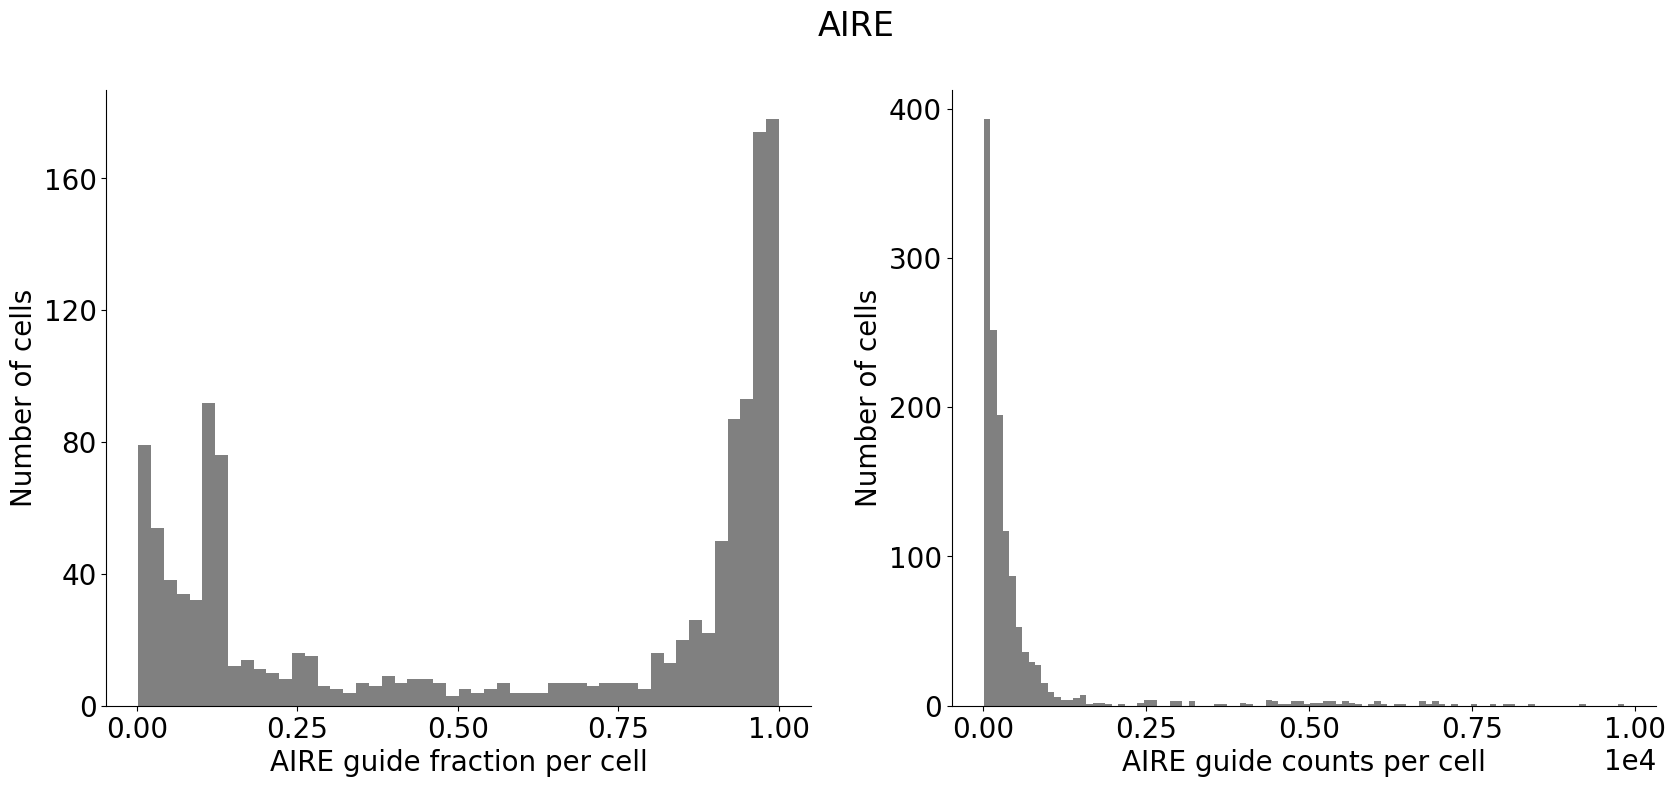

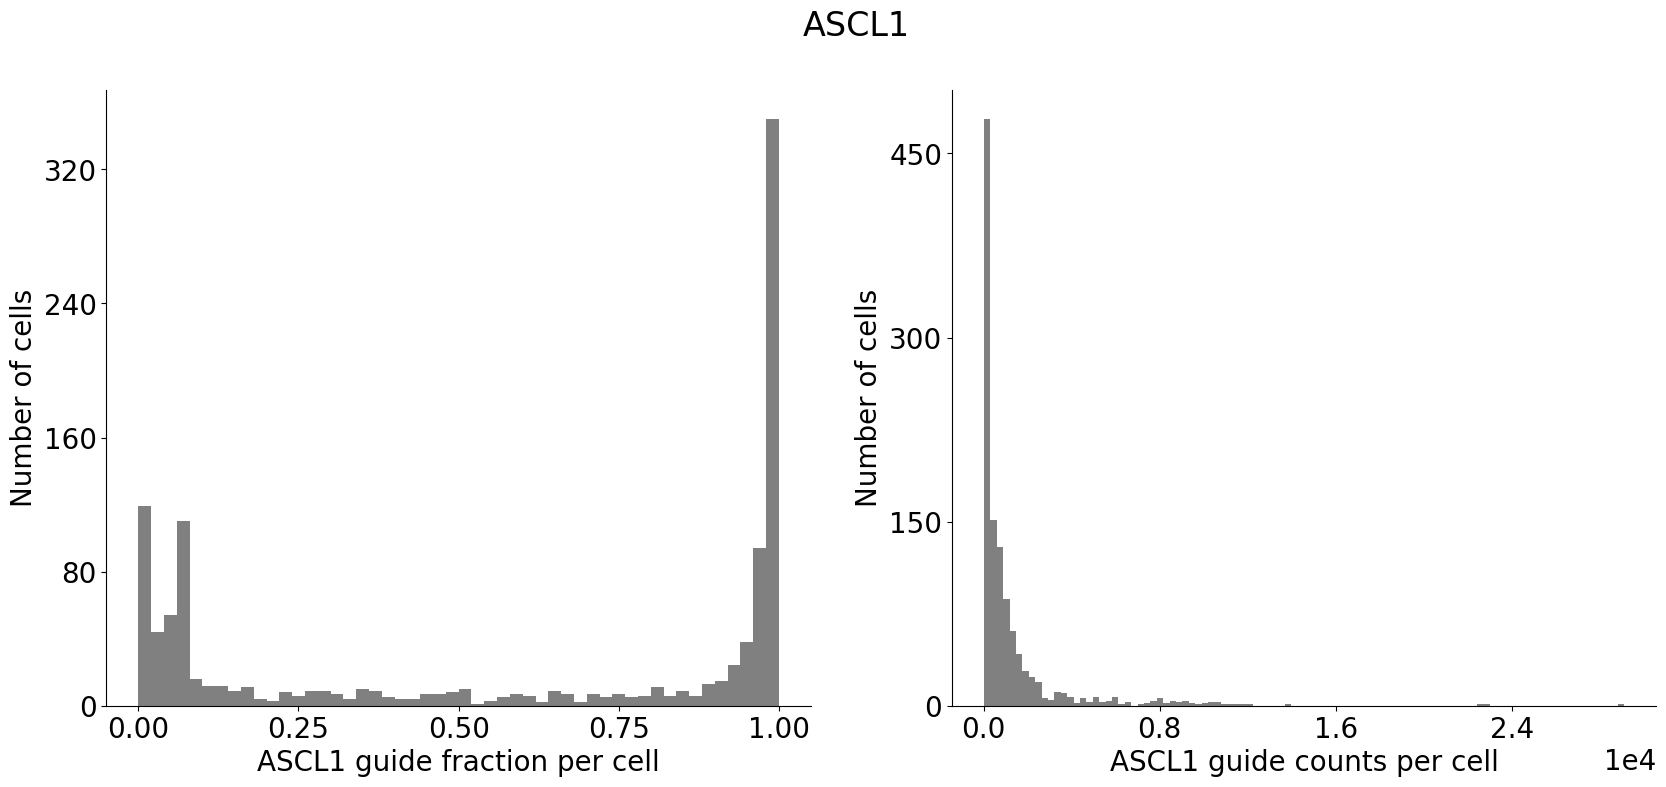

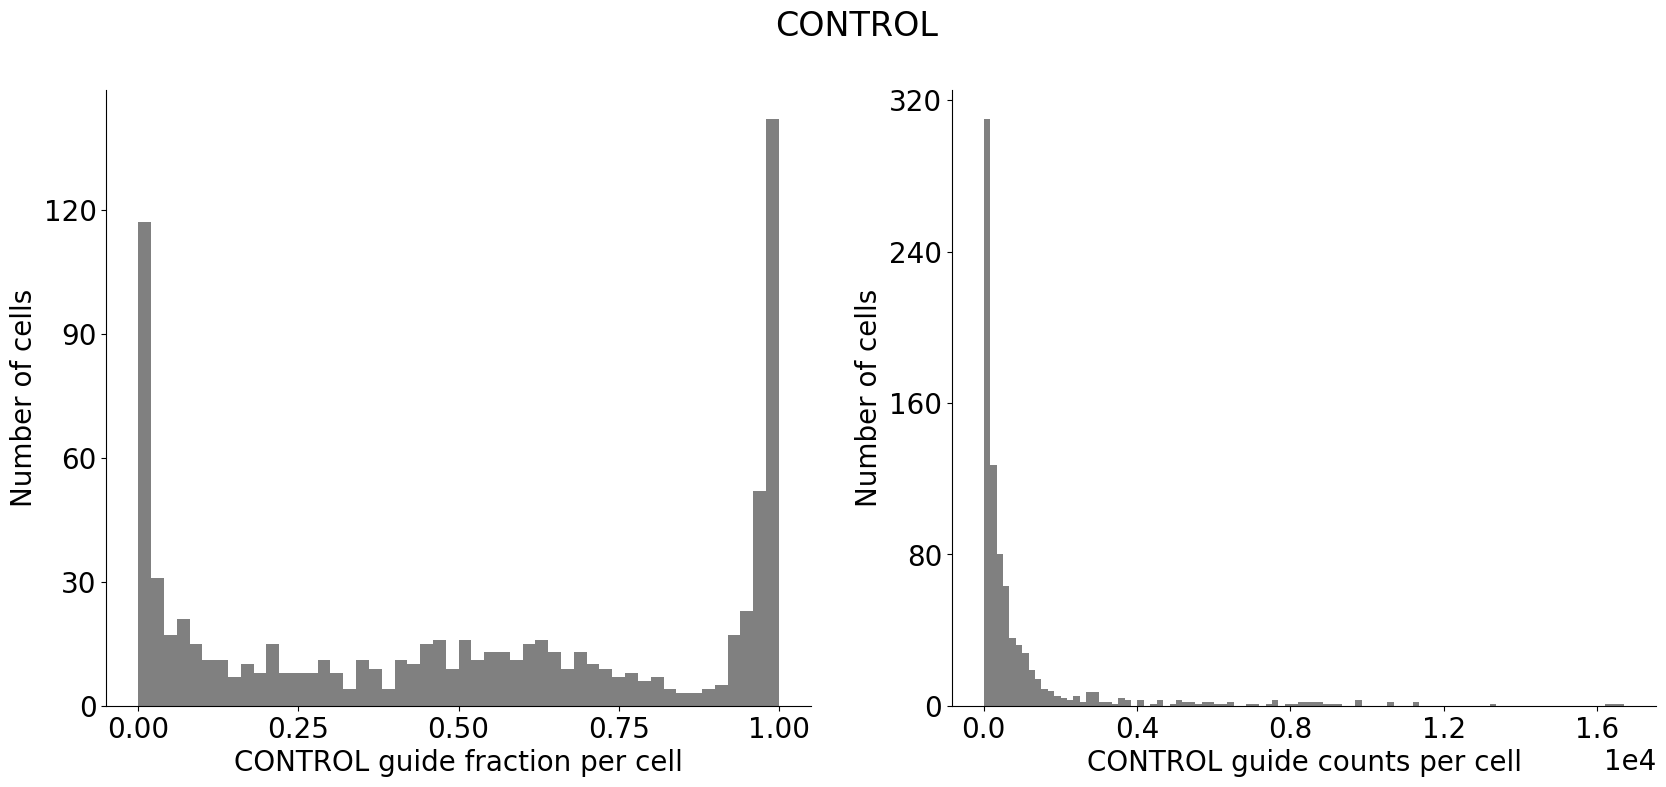

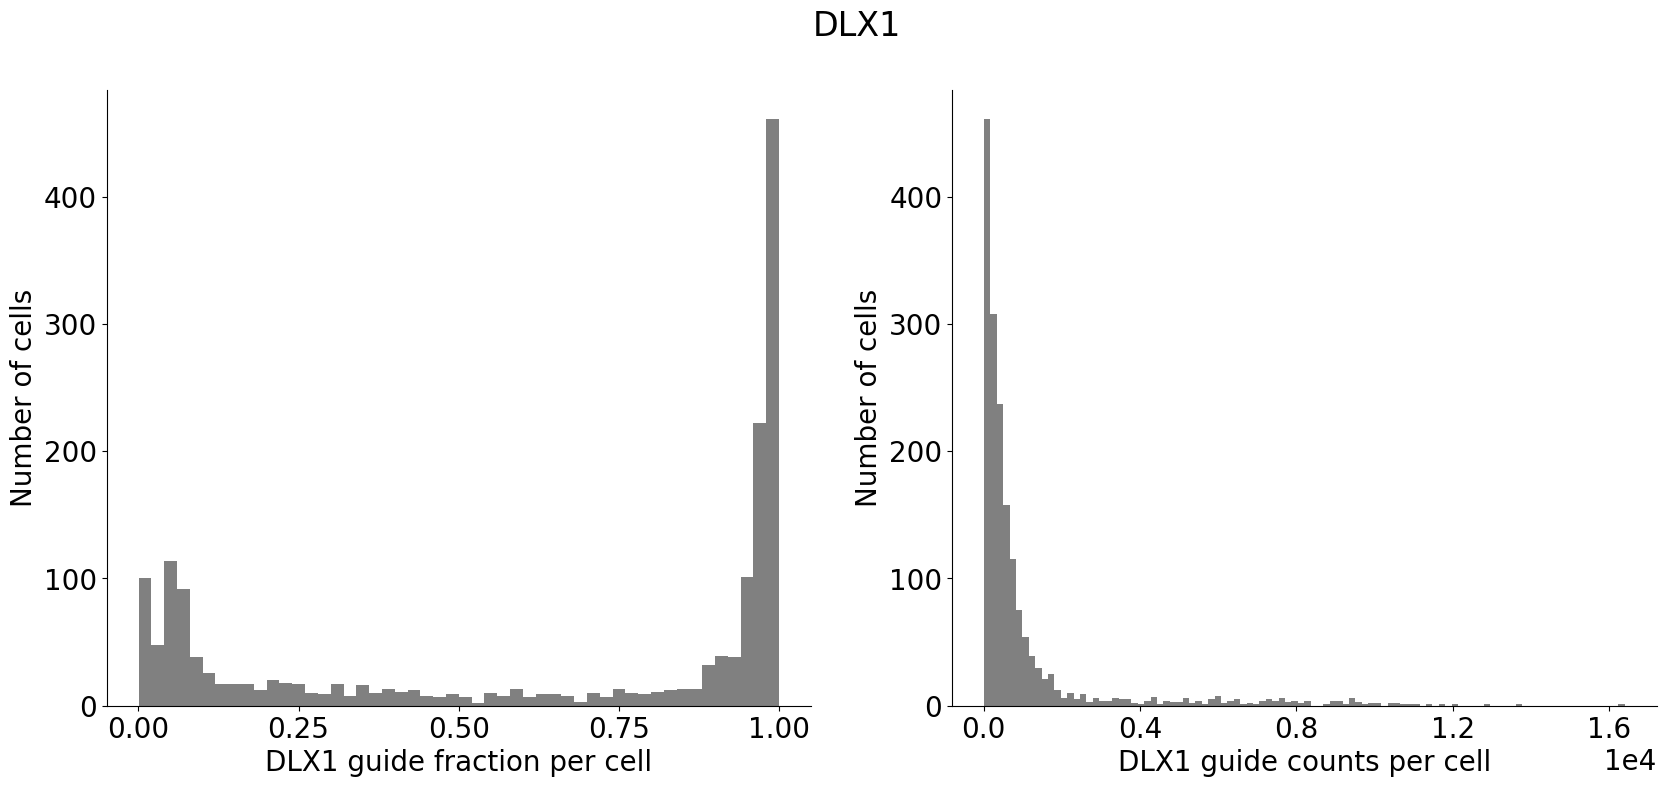

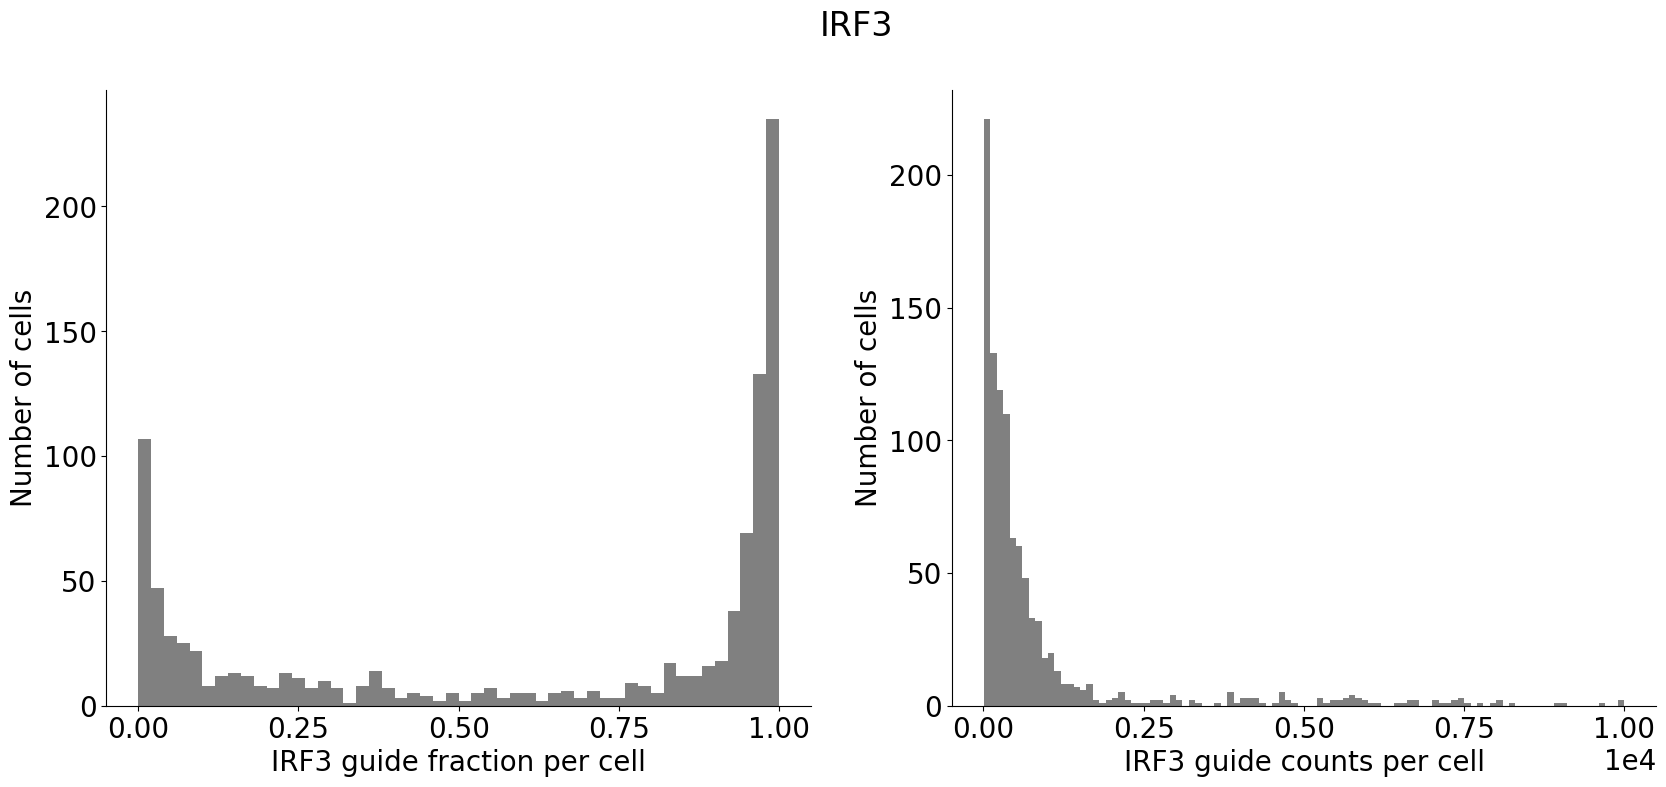

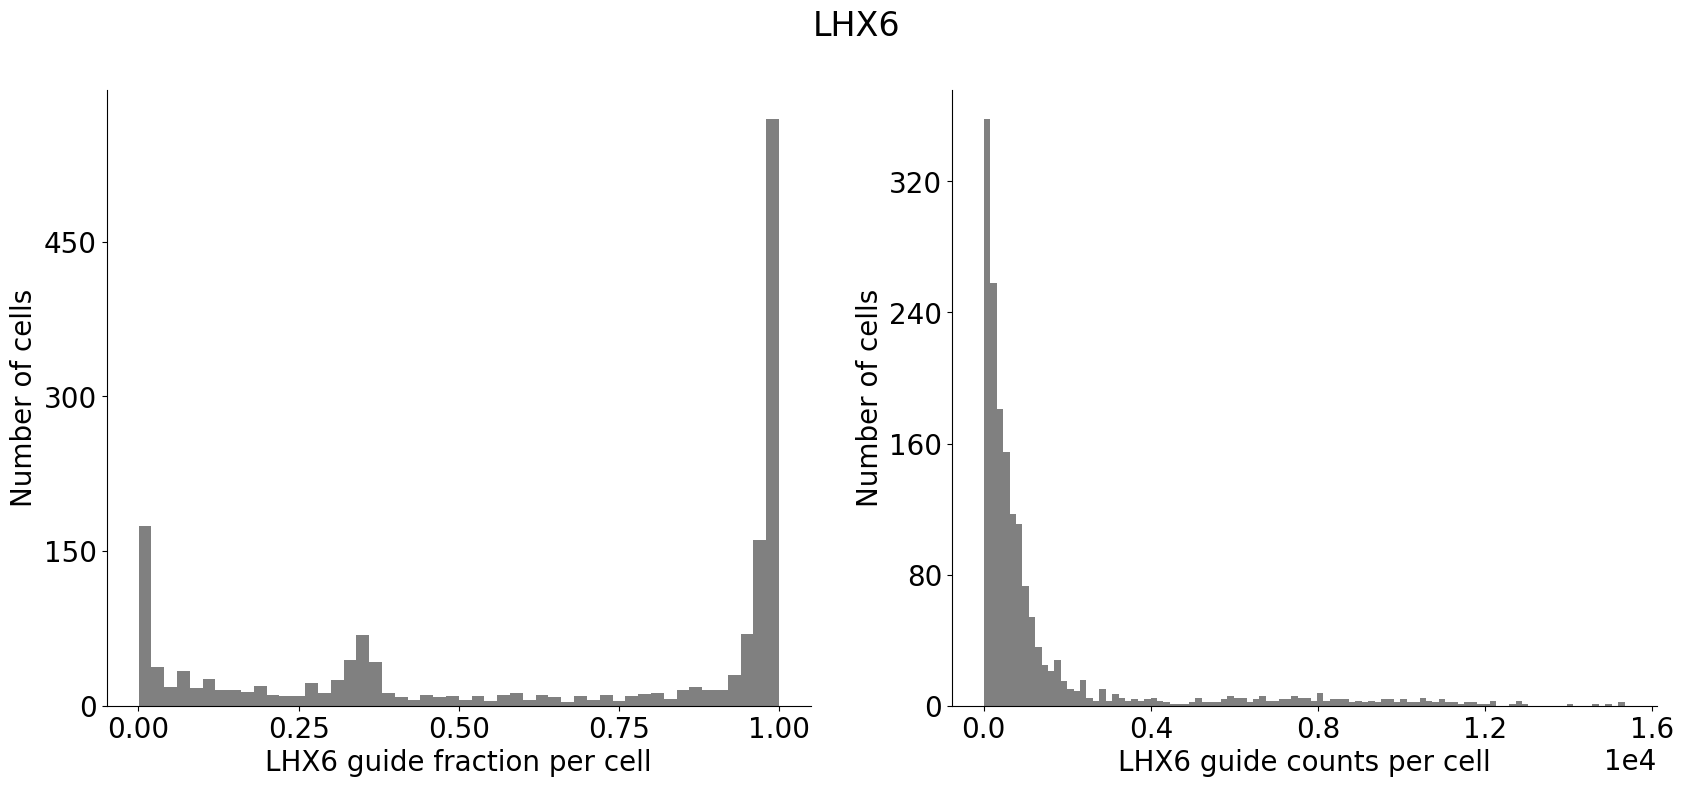

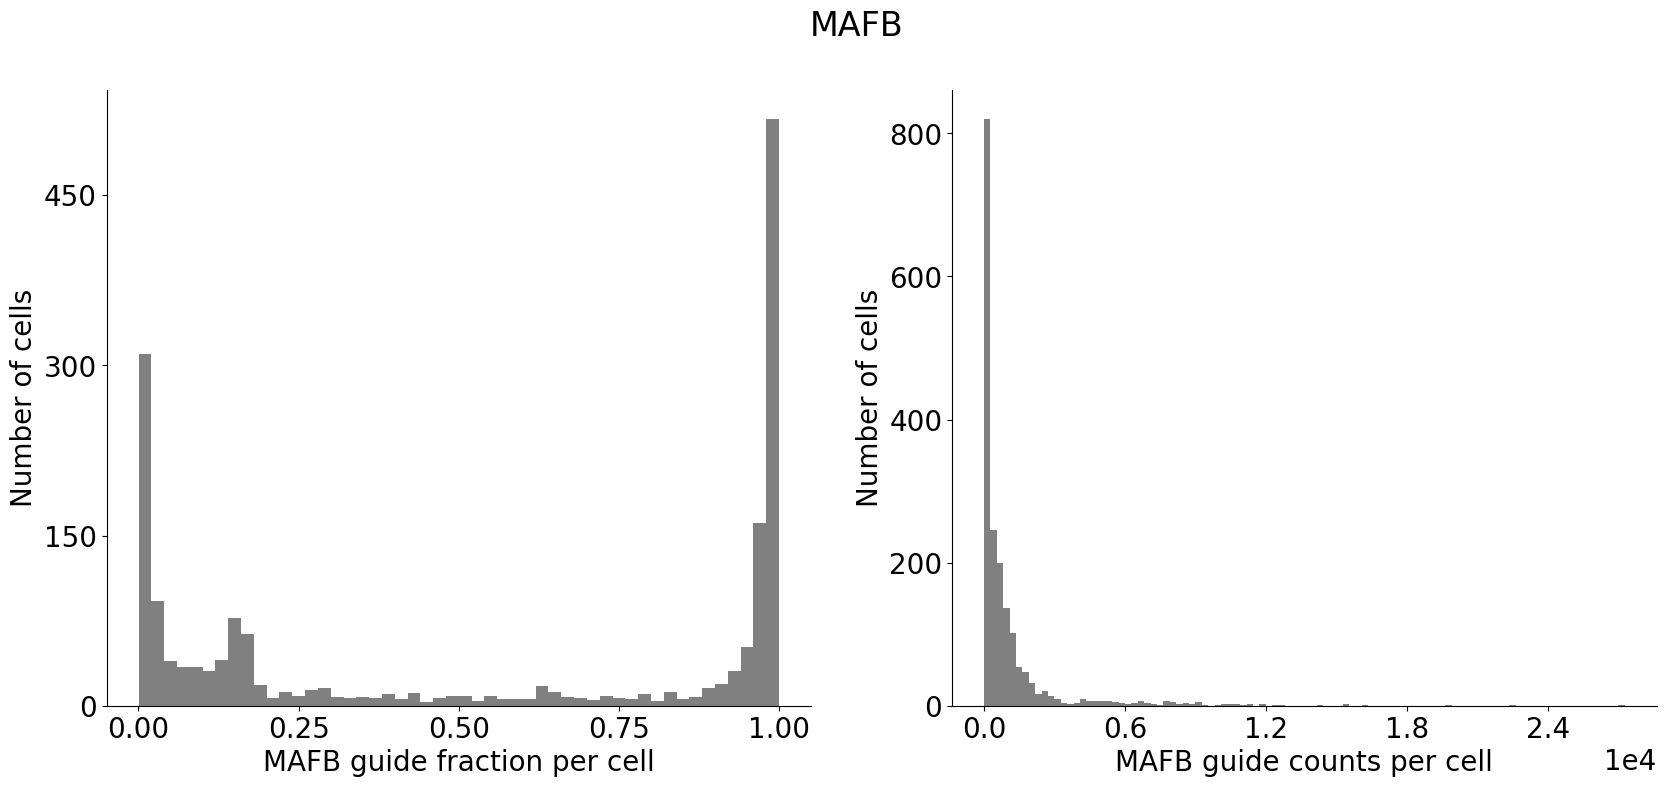

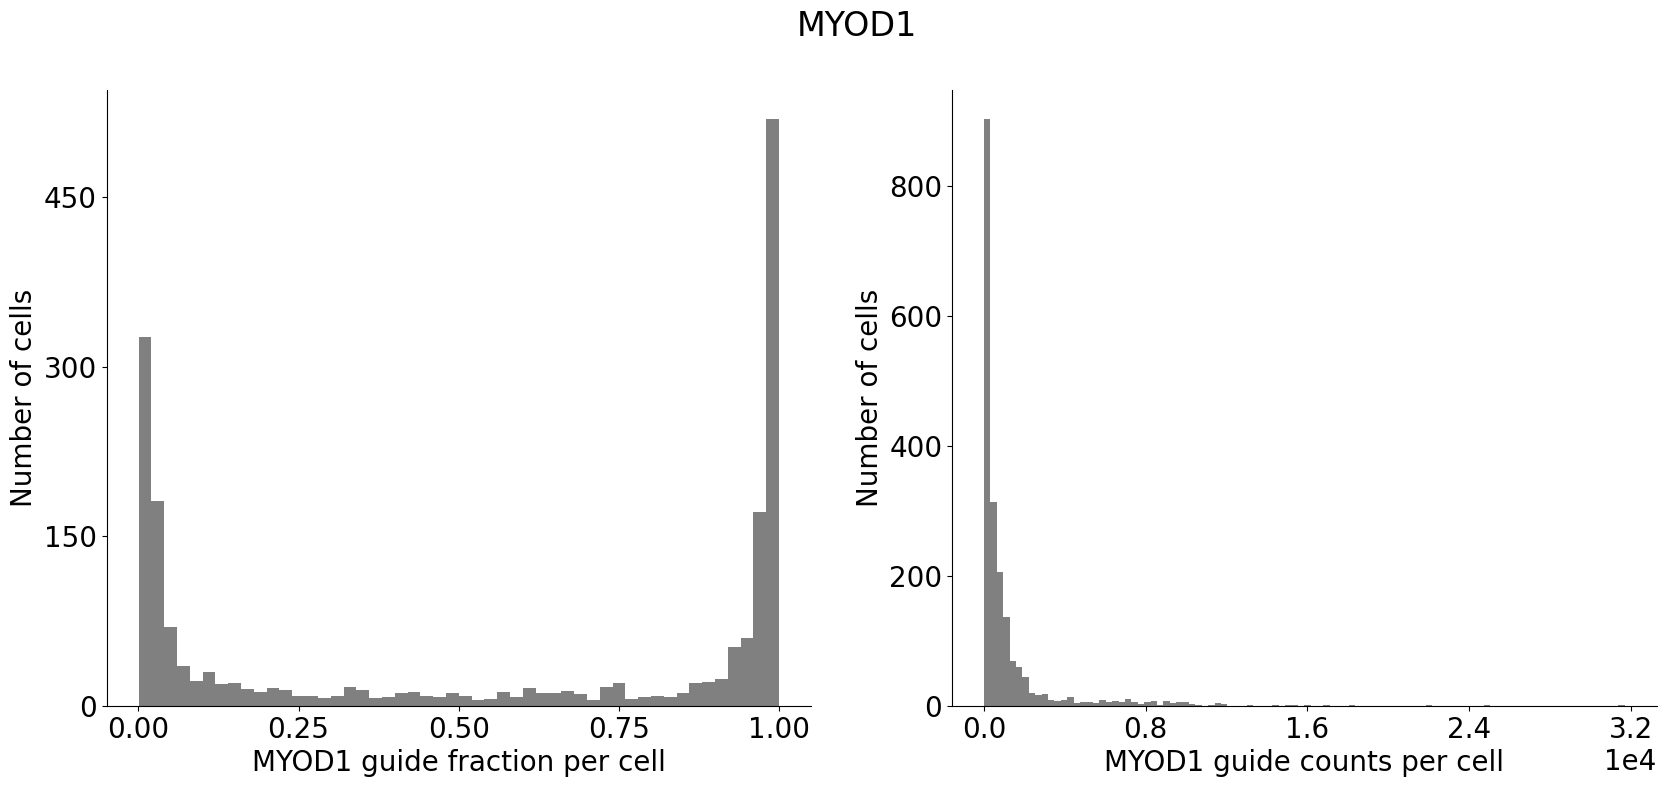

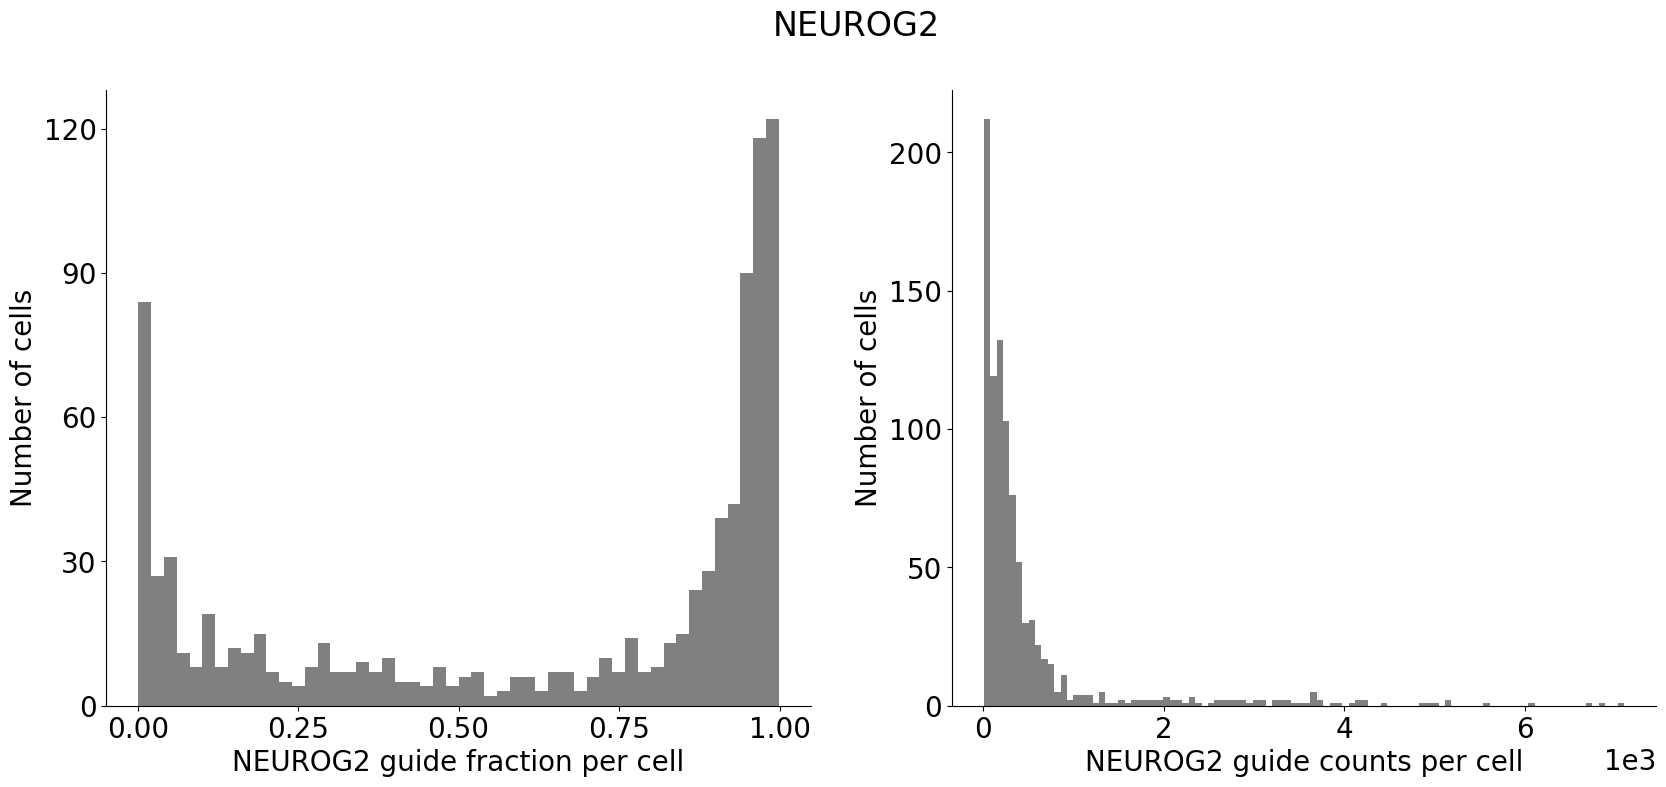

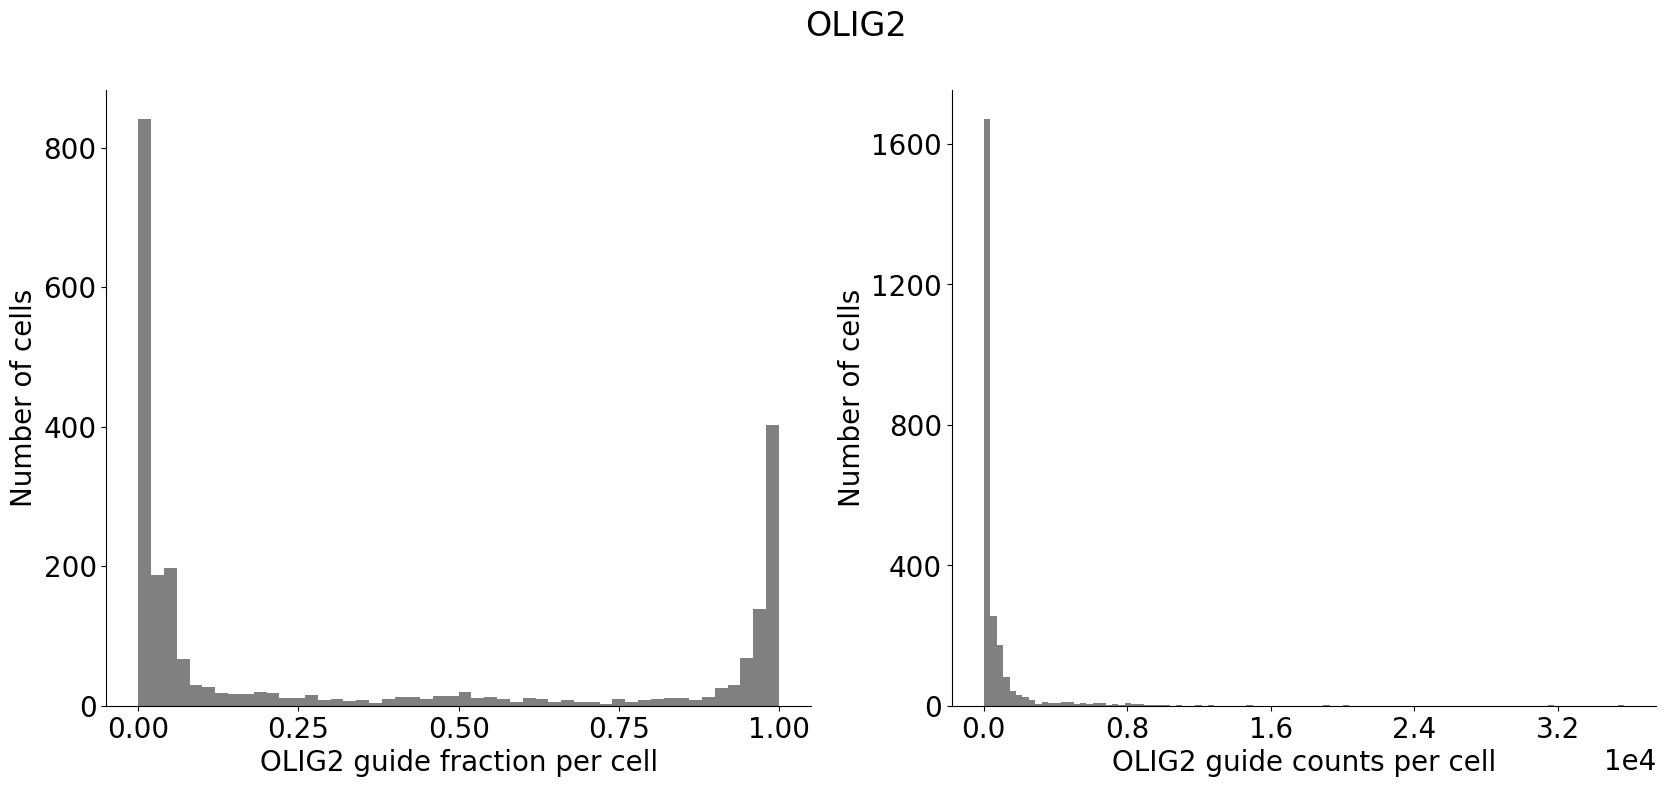

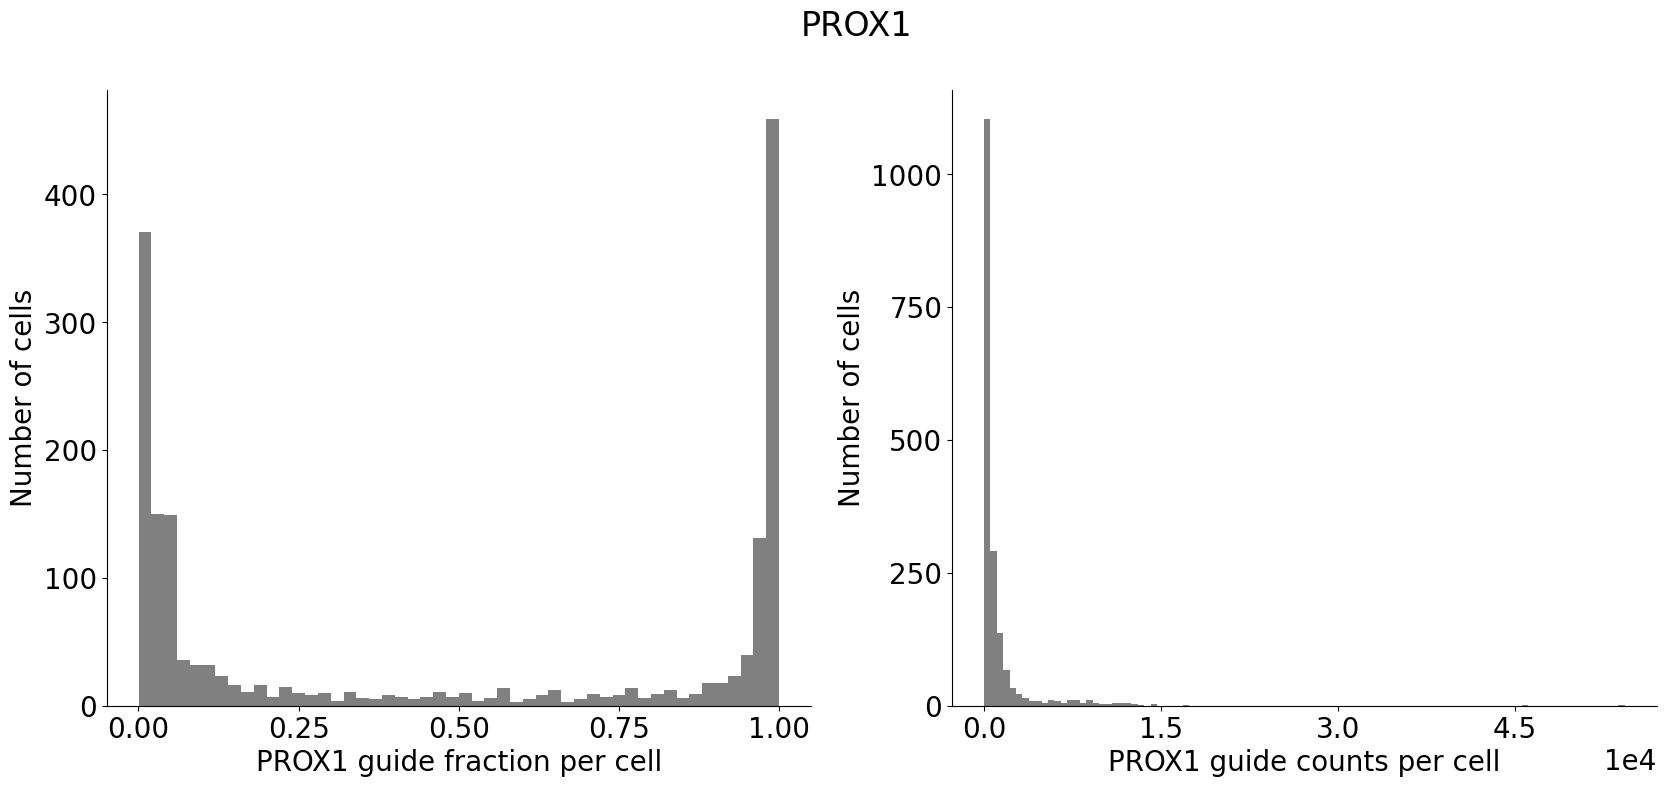

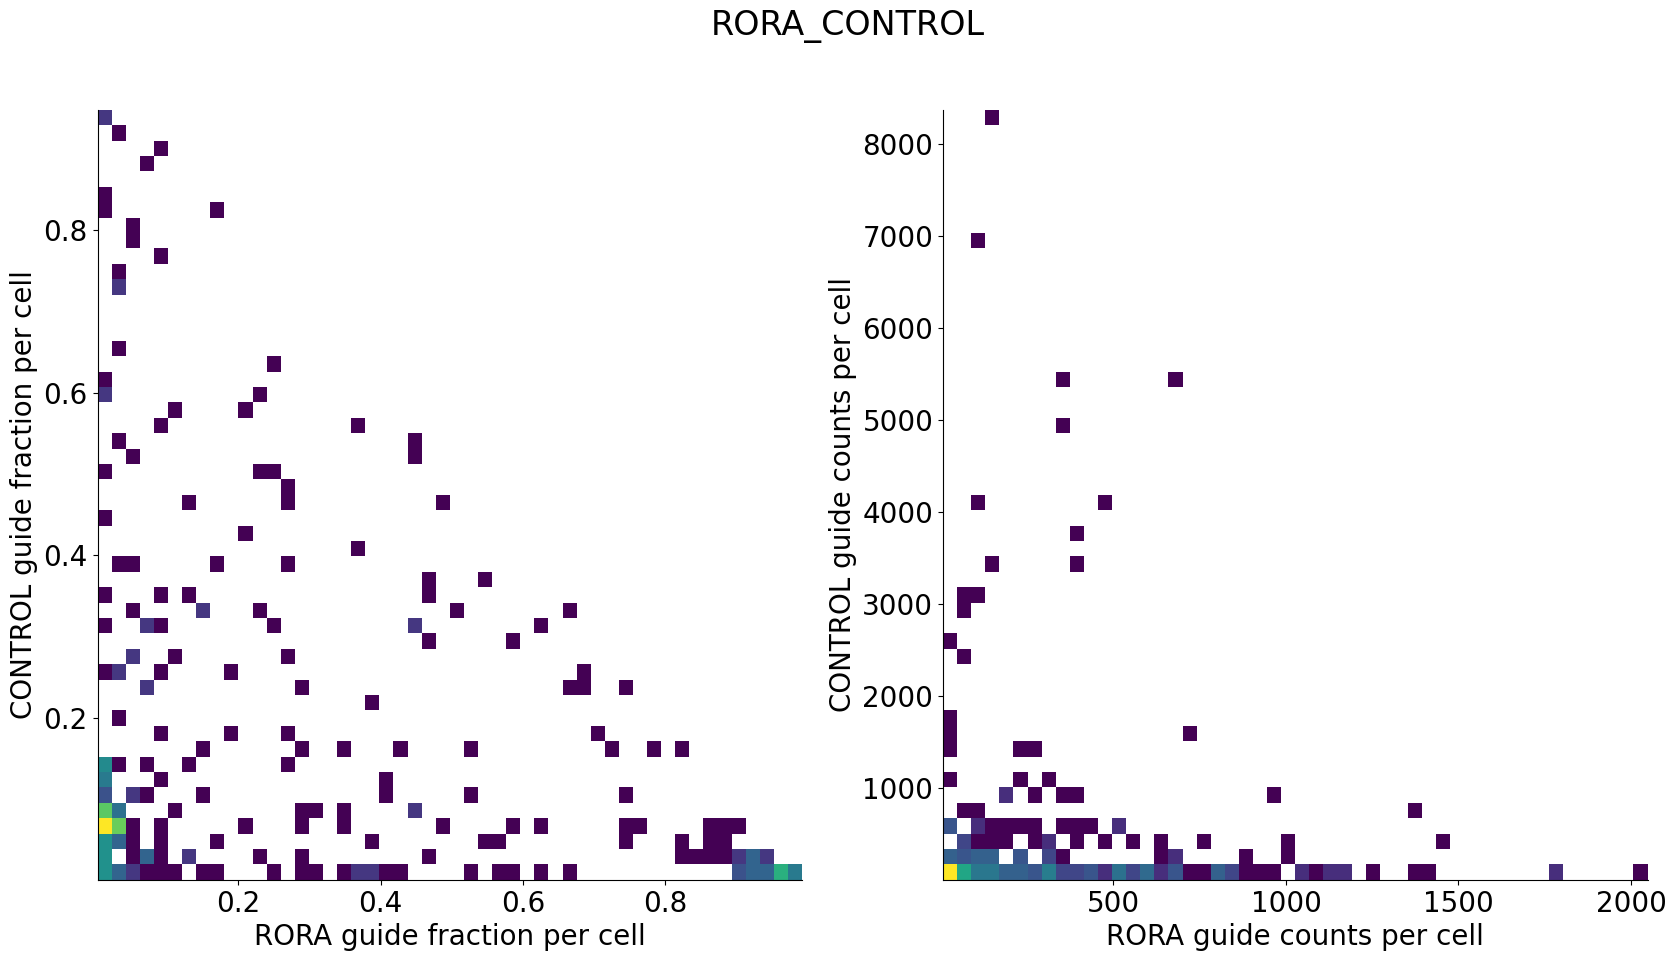

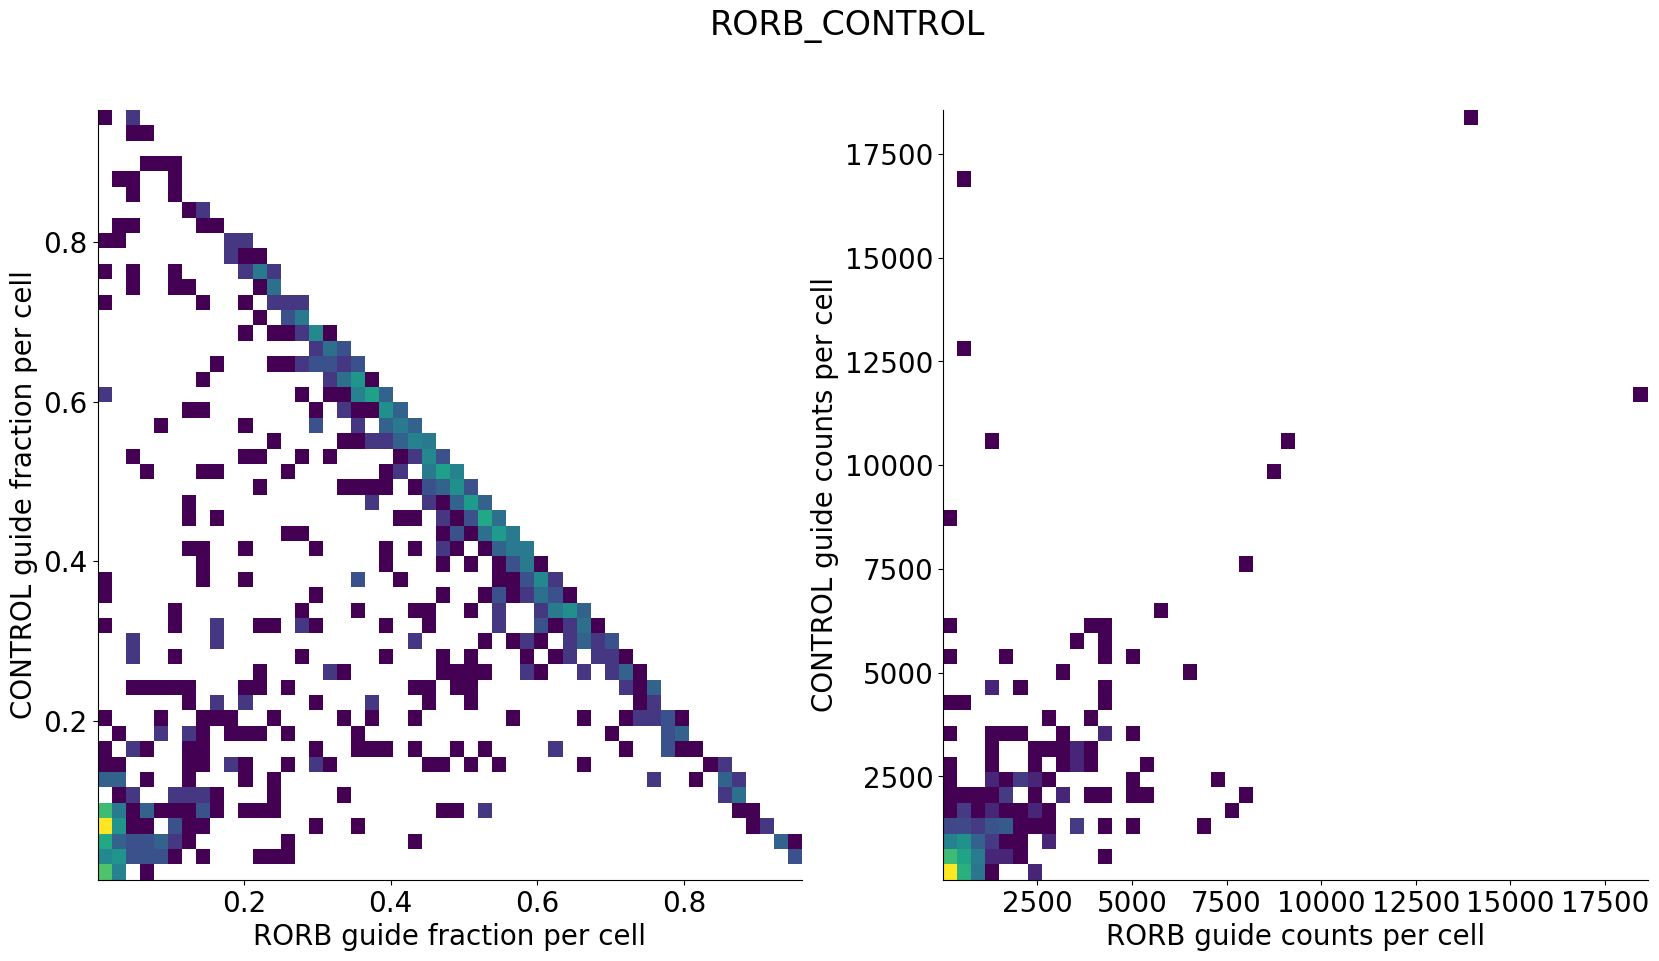

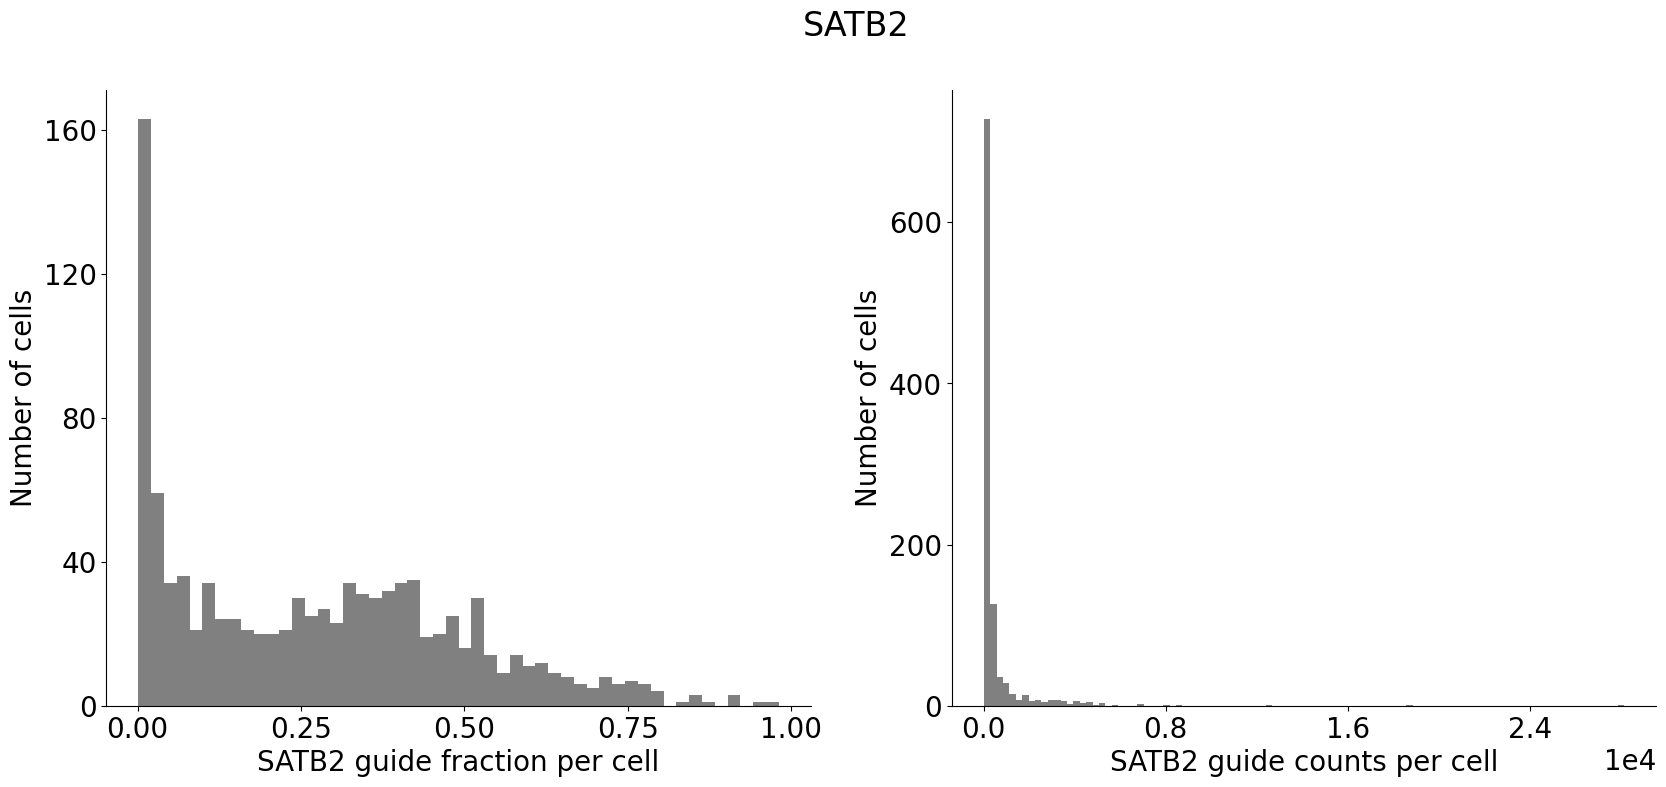

In [56]:
assign_perturbation_state(adata, experimental_design_long,figures_folder, count_threshold=5, frac_threshold=0.6)

not_perturbed    2548
DLX1             1027
MYOD1            1012
LHX6              989
MAFB              912
PROX1             802
OLIG2             791
AIRE              740
RORB_CONTROL      628
ASCL1             622
IRF3              605
NEUROG2           569
CONTROL           363
RORA_CONTROL      112
SATB2              87
Name: pert_state, dtype: int64


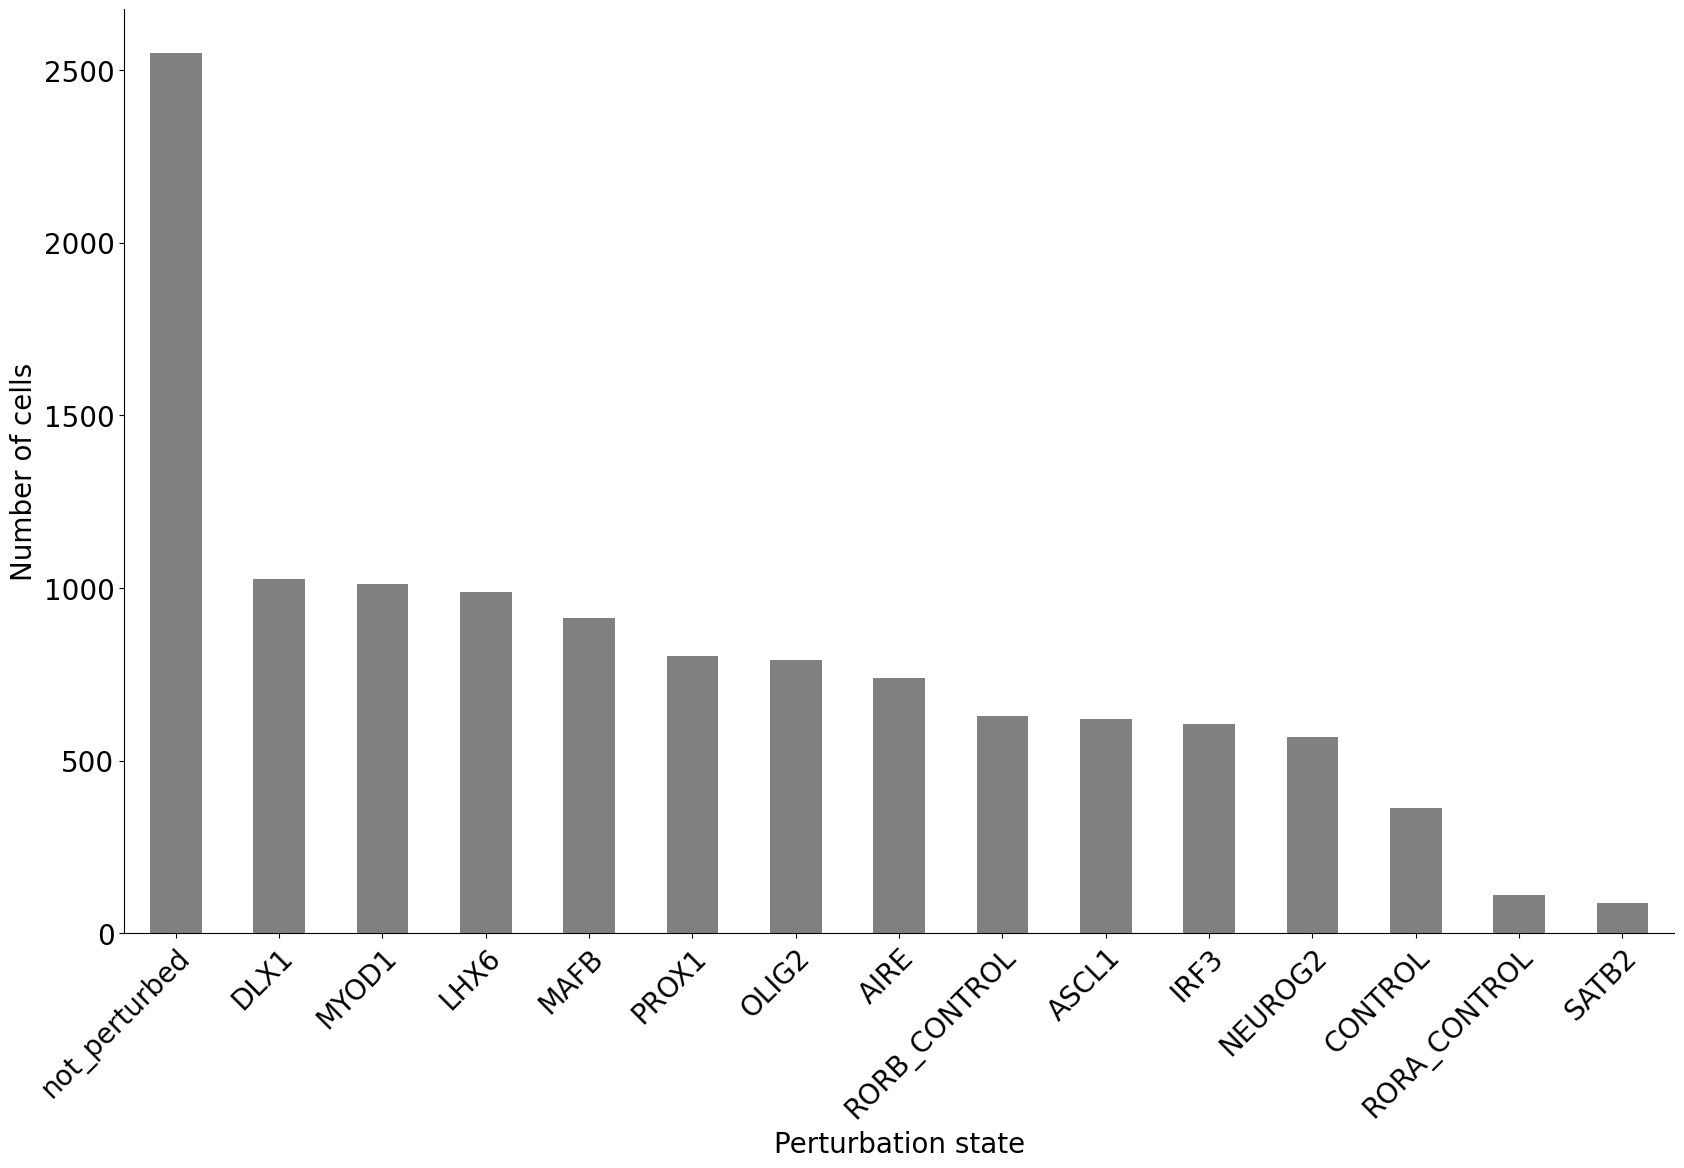

In [59]:
#plot barplot of perturbation state
fig, ax = plt.subplots(figsize=(20, 12))
print(adata.obs['pert_state'].value_counts())
#in greyscale
adata.obs['pert_state'].value_counts().plot.bar(ax=ax, color='grey')
#rotate x axis
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
#add x and y labels, rotate x labels by 45 degrees
ax.set_xlabel('Perturbation state', fontsize=20)
ax.set_ylabel('Number of cells', fontsize=20)
#save figure
fig.savefig(os.path.join(figures_folder, f'{today}_assigned_perturbation_state.pdf'), bbox_inches='tight')

In [35]:
#save adata
adata.write(os.path.join(results_folder, f'{today}_adata_49_04_l3_3_wt_gex_guide_assigned.h5ad'))